# Tracking the Growth of COVID-19 Cases in Global 

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

For a great primer on exponential and logistic growth, watch [this video](https://www.youtube.com/watch?v=Kas0tIxDvrg).

## Important Caveats:

- The growth rate (and the doubling time) changes with time. As the exponential curve eventually turns into a logistic curve, the growth rate will shrink to zero (& the doubling time will consequently increase). **So it's not a good idea to extrapolate trends far into the future based on current growth rates or doubling times.**

- The confirmed cases reported by each country are not the number of infections in each country, only those that have tested positive.

- The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but infections may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [1]:
# Now
! date

2020年  4月 12日 日曜日 14:30:23 JST


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from termcolor import colored, cprint

import plotly.graph_objects as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)

In [3]:
datadir = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
df = pd.read_csv( datadir + 'time_series_covid19_confirmed_global.csv')
#df = pd.read_csv( datadir + 'time_series_covid19_deaths_global.csv')

## Global COVID-19 Analysis

In [4]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases.head()


Total number of cases (in countries with at least 100 cases) as of 4/11/20


4/11/20
Country/Region         
US               526396
Spain            163027
Italy            152271
France           130727
Germany          124908

## Curve Fitting Global COVID-19 Cases

In [5]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country, maxfev=100000, use_plotly=False):
#def plotCases(dataframe, column, country, maxfev=1):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    if(use_plotly is False):
        plt.figure(figsize=(10,5))
        plt.plot(x, y, 'ko', label="Original Data")
    else:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Original Data'))
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=maxfev)
        lerror = np.sqrt(np.diag(lpcov))

        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])

        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  

        if logisticr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=logistic(x, *lpopt), mode='lines', line=dict(dash='dot'), name="Logistic Curve Fit") )
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            print("\tparam: ", lpopt)
            logisticworked = True
        else:
            print("\n logistic R^2 ", logisticr2)    
    except Exception as ex:
        cprint('\nException in logstic process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=maxfev)
        eerror = np.sqrt(np.diag(epcov))

        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])

        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)

        if expr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=exponential(x, *epopt), mode='lines', line=dict(dash='dot'), name="Exponential Curve Fit"))
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            print("\tparam: ", epopt)
            exponentialworked = True
        else:
            print("\n exponential R^2 ", expr2)    
    except Exception as ex:
        cprint('\nException in exponential process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    if(use_plotly == False):
        plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
        plt.xlabel('Days', fontsize="x-large")
        plt.ylabel('Total Cases', fontsize="x-large")
        plt.legend(fontsize="x-large")
        plt.show()
    else:
        fig.update_layout(title=country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')'
                          ,  xaxis_title='Days'
                          , yaxis_title='Total Cases'
                          , width=900, height=700,  autosize=False
                          #,paper_bgcolor='black'
                         )
        fig.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 526396
	Confirmed cases on 4/4/20 	 308853
	Ratio: 1.7
	Weekly increase: 70.4 %
	Daily increase: 7.9 % per day
	Doubling Time (represents recent growth): 9.1 days

** Based on Logistic Fit**

	R^2: 0.9993134286884687
	Doubling Time (during middle of growth):  6.88 (± 0.2 ) days
	param:  [ 2.80669176e+06  2.01418556e-01 -1.29790934e+03  6.61978910e+05]

** Based on Exponential Fit **

	R^2: 0.9830201183861744
	Doubling Time (represents overall growth):  6.19 (± 0.38 ) days
	param:  [  75.11478341    0.11200126 -100.        ]


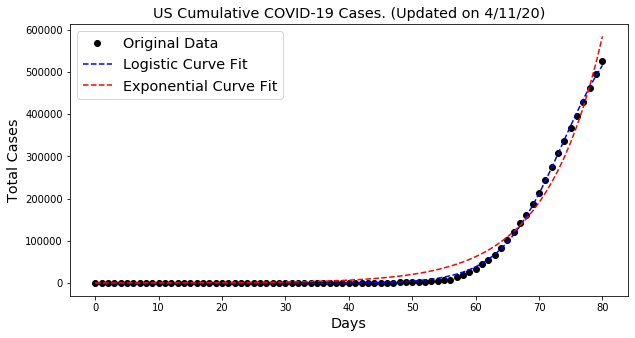



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 163027
	Confirmed cases on 4/4/20 	 126168
	Ratio: 1.29
	Weekly increase: 29.2 %
	Daily increase: 3.7 % per day
	Doubling Time (represents recent growth): 18.9 days

** Based on Logistic Fit**

	R^2: 0.9994892076792664
	Doubling Time (during middle of growth):  7.09 (± 0.18 ) days
	param:  [ 8.22233894e+04  1.95488097e-01 -5.30220028e+02  1.74128240e+05]

 exponential R^2  0.9244102854270381


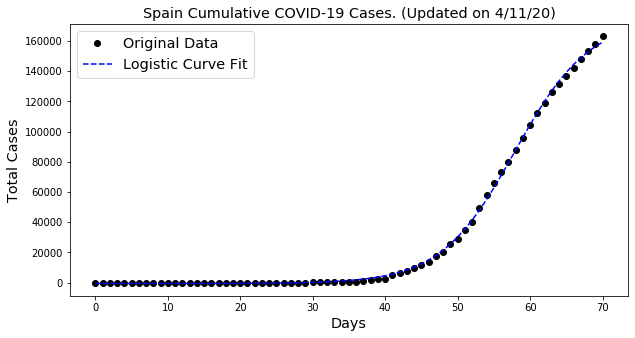



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 152271
	Confirmed cases on 4/4/20 	 124632
	Ratio: 1.22
	Weekly increase: 22.2 %
	Daily increase: 2.9 % per day
	Doubling Time (represents recent growth): 24.2 days

** Based on Logistic Fit**

	R^2: 0.9989499119366256
	Doubling Time (during middle of growth):  9.19 (± 0.34 ) days
	param:  [ 3.99342032e+03  1.50798479e-01 -1.06735342e+03  1.59658440e+05]

 exponential R^2  0.8215249541434285


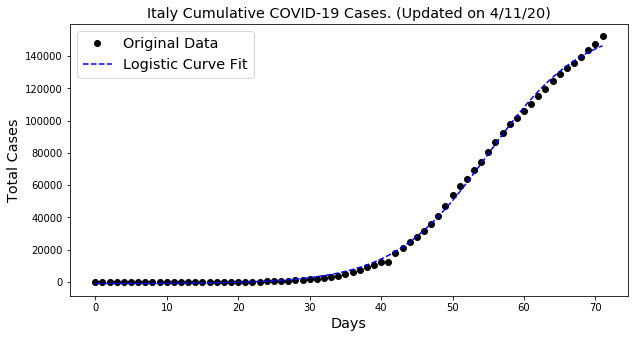



France

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 130727
	Confirmed cases on 4/4/20 	 90848
	Ratio: 1.44
	Weekly increase: 43.9 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.3 days

** Based on Logistic Fit**

	R^2: 0.9967342261944605
	Doubling Time (during middle of growth):  8.47 (± 0.57 ) days
	param:  [ 1.46097557e+05  1.63729559e-01 -9.44830112e+01  1.89092818e+05]

** Based on Exponential Fit **

	R^2: 0.9849334719570725
	Doubling Time (represents overall growth):  7.0 (± 0.42 ) days
	param:  [ 6.56868097e+01  9.89523148e-02 -1.00000000e+02]


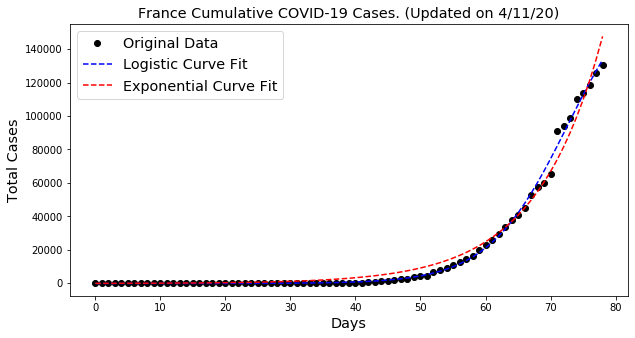



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 124908
	Confirmed cases on 4/4/20 	 96092
	Ratio: 1.3
	Weekly increase: 30.0 %
	Daily increase: 3.8 % per day
	Doubling Time (represents recent growth): 18.5 days

** Based on Logistic Fit**

	R^2: 0.9991929652089444
	Doubling Time (during middle of growth):  7.59 (± 0.24 ) days
	param:  [ 1.02943597e+05  1.82622702e-01 -4.59559098e+02  1.36773653e+05]

 exponential R^2  0.9496234588843043


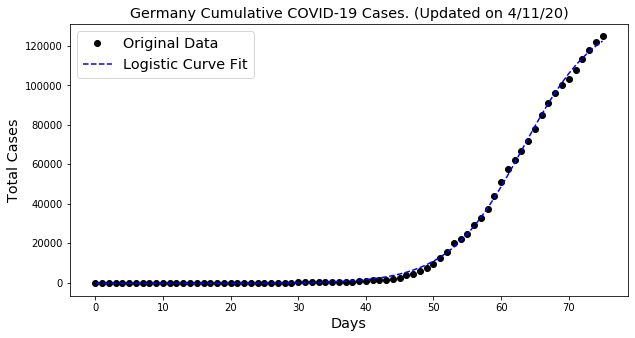



China

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 83014
	Confirmed cases on 4/4/20 	 82543
	Ratio: 1.01
	Weekly increase: 0.6 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 852.7 days

** Based on Logistic Fit**

	R^2: 0.9958381268635392
	Doubling Time (during middle of growth):  6.63 (± 0.45 ) days
	param:  [ 3.96282645e+01  2.09181237e-01 -1.72119620e+03  8.16462975e+04]

 exponential R^2  -2.6287020251035935


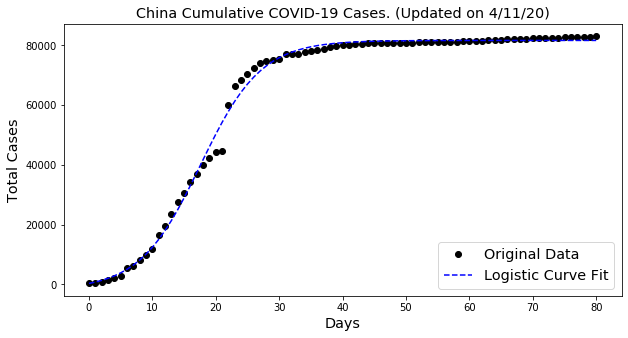



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 79874
	Confirmed cases on 4/4/20 	 42477
	Ratio: 1.88
	Weekly increase: 88.0 %
	Daily increase: 9.4 % per day
	Doubling Time (represents recent growth): 7.7 days

** Based on Logistic Fit**

	R^2: 0.9991065229928242
	Doubling Time (during middle of growth):  7.87 (± 0.3 ) days
	param:  [ 1.41148814e+05  1.76111718e-01 -1.88249715e+02  1.19144056e+05]

** Based on Exponential Fit **

	R^2: 0.9903812323337942
	Doubling Time (represents overall growth):  6.08 (± 0.3 ) days
	param:  [  26.30402994    0.11392244 -100.        ]


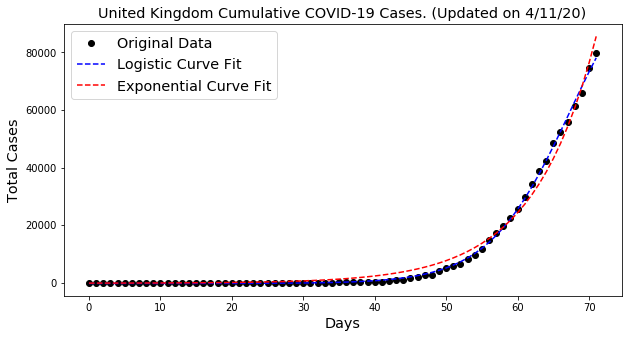



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 70029
	Confirmed cases on 4/4/20 	 55743
	Ratio: 1.26
	Weekly increase: 25.6 %
	Daily increase: 3.3 % per day
	Doubling Time (represents recent growth): 21.3 days

** Based on Logistic Fit**

	R^2: 0.9975748021845977
	Doubling Time (during middle of growth):  13.93 (± 1.32 ) days
	param:  [ 7.77576828e+01  9.94878828e-02 -1.86811740e+03  1.03929253e+05]

 exponential R^2  0.7001127250385121


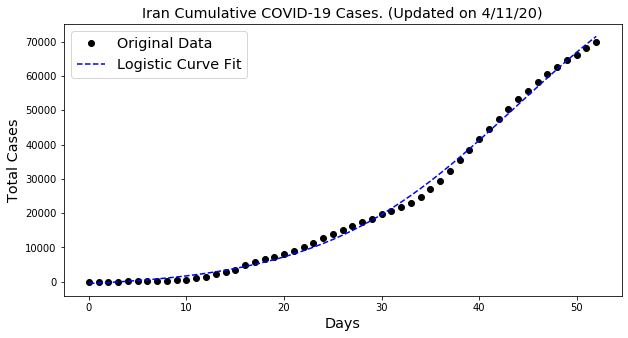



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 52167
	Confirmed cases on 4/4/20 	 23934
	Ratio: 2.18
	Weekly increase: 118.0 %
	Daily increase: 11.8 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.998316226227041
	Doubling Time (during middle of growth):  7.31 (± 0.72 ) days
	param:  [ 2.38420682e+02  1.89577099e-01 -1.15320487e+03  8.60438460e+04]

 exponential R^2  0.903086019326919


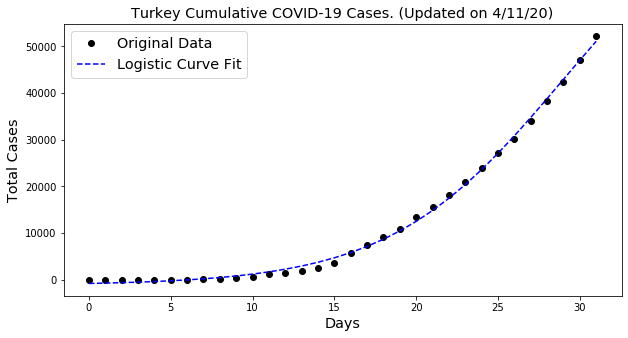



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 28018
	Confirmed cases on 4/4/20 	 18431
	Ratio: 1.52
	Weekly increase: 52.0 %
	Daily increase: 6.2 % per day
	Doubling Time (represents recent growth): 11.6 days

** Based on Logistic Fit**

	R^2: 0.9987460563713783
	Doubling Time (during middle of growth):  7.59 (± 0.33 ) days
	param:  [ 4.59190887e+04  1.82657237e-01 -8.00418533e+01  3.32588487e+04]

** Based on Exponential Fit **

	R^2: 0.9788300008390507
	Doubling Time (represents overall growth):  7.31 (± 0.59 ) days
	param:  [ 5.46787542e+01  9.48073672e-02 -1.00000000e+02]


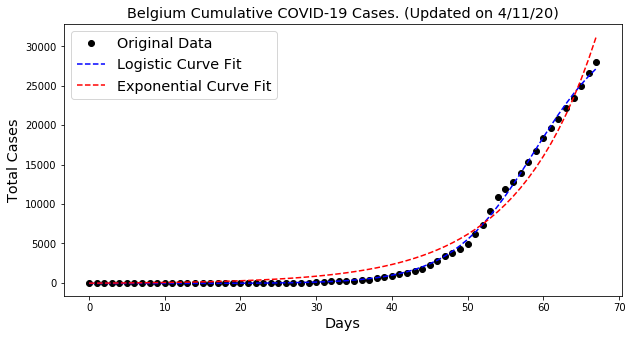



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 25107
	Confirmed cases on 4/4/20 	 20505
	Ratio: 1.22
	Weekly increase: 22.4 %
	Daily increase: 2.9 % per day
	Doubling Time (represents recent growth): 24.0 days

** Based on Logistic Fit**

	R^2: 0.9978805815612674
	Doubling Time (during middle of growth):  7.79 (± 0.52 ) days
	param:  [ 2.57670861e+02  1.77902907e-01 -4.52798241e+02  2.61036480e+04]

 exponential R^2  0.7459610671788153


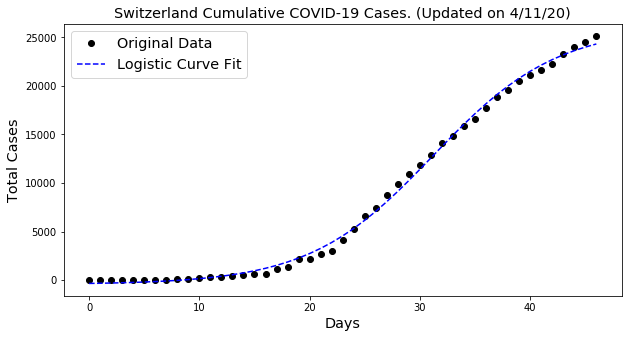



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 24571
	Confirmed cases on 4/4/20 	 16727
	Ratio: 1.47
	Weekly increase: 46.9 %
	Daily increase: 5.6 % per day
	Doubling Time (represents recent growth): 12.6 days

** Based on Logistic Fit**

	R^2: 0.9985853482349281
	Doubling Time (during middle of growth):  8.83 (± 0.56 ) days
	param:  [ 2.30002469e+02  1.57063716e-01 -3.72939744e+02  2.91394903e+04]

 exponential R^2  0.8751390283866336


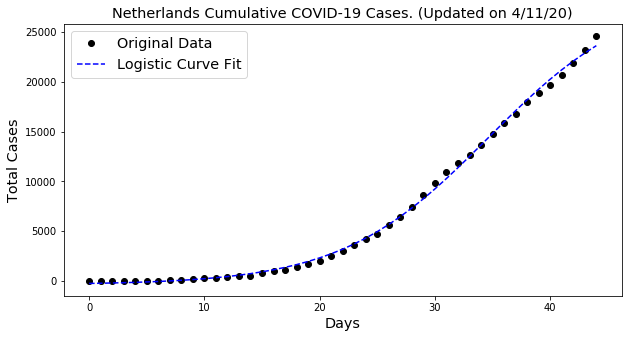



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 23316
	Confirmed cases on 4/4/20 	 12978
	Ratio: 1.8
	Weekly increase: 79.7 %
	Daily increase: 8.7 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.9991971756698844
	Doubling Time (during middle of growth):  7.05 (± 0.23 ) days
	param:  [ 9.00779500e+05  1.96676817e-01 -4.13081263e+01  2.96907229e+04]

** Based on Exponential Fit **

	R^2: 0.9841561551976161
	Doubling Time (represents overall growth):  6.39 (± 0.39 ) days
	param:  [   6.84453645    0.10847132 -100.        ]


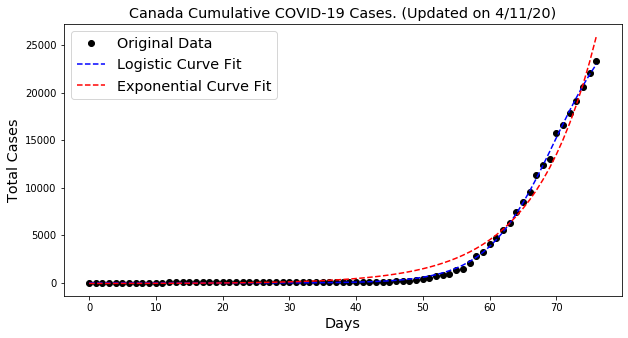



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 20727
	Confirmed cases on 4/4/20 	 10360
	Ratio: 2.0
	Weekly increase: 100.1 %
	Daily increase: 10.4 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9984740344119339
	Doubling Time (during middle of growth):  8.51 (± 0.61 ) days
	param:  [ 1.56229088e+03  1.62823100e-01 -1.52384001e+02  4.29074303e+04]

** Based on Exponential Fit **

	R^2: 0.9935581782059871
	Doubling Time (represents overall growth):  5.68 (± 0.32 ) days
	param:  [  92.31919227    0.122094   -100.        ]


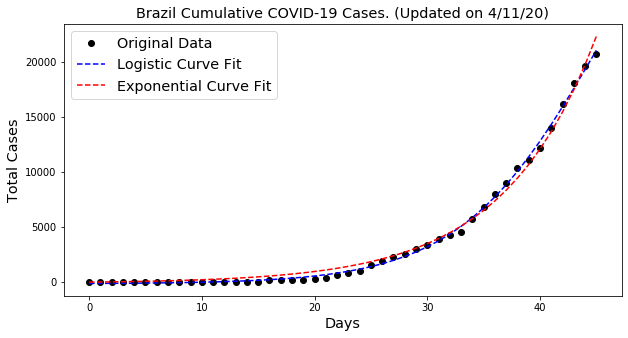



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 15987
	Confirmed cases on 4/4/20 	 10524
	Ratio: 1.52
	Weekly increase: 51.9 %
	Daily increase: 6.2 % per day
	Doubling Time (represents recent growth): 11.6 days

** Based on Logistic Fit**

	R^2: 0.9974690550622801
	Doubling Time (during middle of growth):  7.43 (± 0.64 ) days
	param:  [ 3.41970016e+02  1.86668399e-01 -2.45368281e+02  1.84252708e+04]

 exponential R^2  0.918133397370067


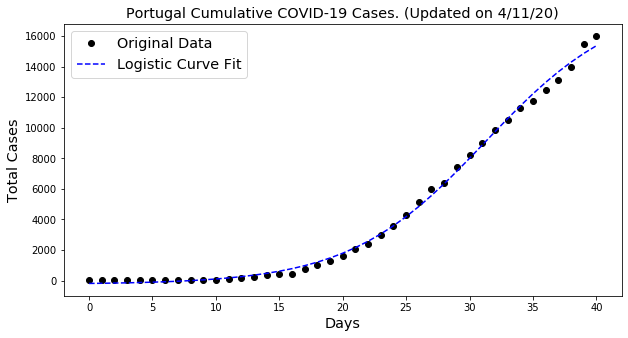



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 13806
	Confirmed cases on 4/4/20 	 11781
	Ratio: 1.17
	Weekly increase: 17.2 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 30.6 days

** Based on Logistic Fit**

	R^2: 0.9990075741316692
	Doubling Time (during middle of growth):  6.05 (± 0.26 ) days
	param:  [ 1.03137452e+03  2.29094354e-01 -8.92451598e+01  1.36840015e+04]

 exponential R^2  0.7912359893633856


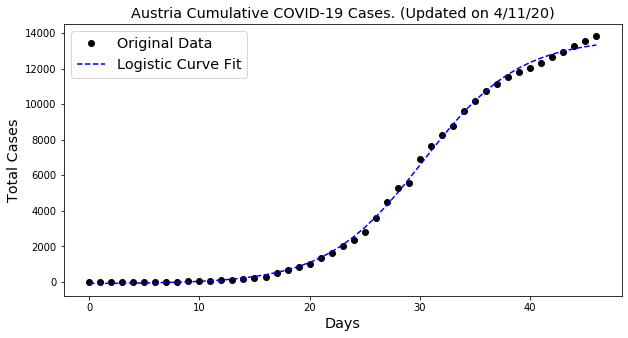



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 13584
	Confirmed cases on 4/4/20 	 4731
	Ratio: 2.87
	Weekly increase: 187.1 %
	Daily increase: 16.3 % per day
	Doubling Time (represents recent growth): 4.6 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9985325984548861
	Doubling Time (represents overall growth):  4.35 (± 0.08 ) days
	param:  [  0.17152991   0.15925348 -52.85759503]


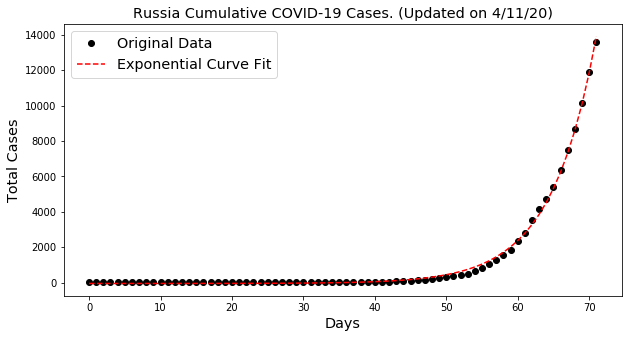



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 10743
	Confirmed cases on 4/4/20 	 7851
	Ratio: 1.37
	Weekly increase: 36.8 %
	Daily increase: 4.6 % per day
	Doubling Time (represents recent growth): 15.5 days

** Based on Logistic Fit**

	R^2: 0.9986513039966751
	Doubling Time (during middle of growth):  5.74 (± 0.29 ) days
	param:  [ 1.30573060e+04  2.41317635e-01 -2.47642172e+01  1.12231169e+04]

** Based on Exponential Fit **

	R^2: 0.9543307507286116
	Doubling Time (represents overall growth):  7.13 (± 1.09 ) days
	param:  [ 1.00000000e+02  9.72682528e-02 -1.00000000e+02]


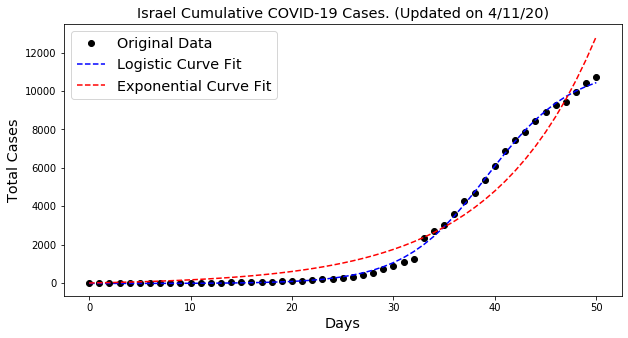



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 10480
	Confirmed cases on 4/4/20 	 10156
	Ratio: 1.03
	Weekly increase: 3.2 %
	Daily increase: 0.4 % per day
	Doubling Time (represents recent growth): 154.5 days

** Based on Logistic Fit**

	R^2: 0.9902173521269773
	Doubling Time (during middle of growth):  6.59 (± 0.71 ) days
	param:  [ 6.11604931e+03  2.10243210e-01 -1.51202402e+02  9.63583912e+03]

 exponential R^2  0.5438249280010932


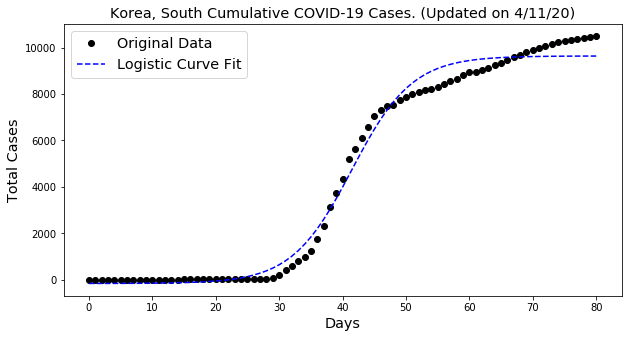



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 10151
	Confirmed cases on 4/4/20 	 6443
	Ratio: 1.58
	Weekly increase: 57.6 %
	Daily increase: 6.7 % per day
	Doubling Time (represents recent growth): 10.7 days

** Based on Logistic Fit**

	R^2: 0.9986892187084301
	Doubling Time (during middle of growth):  12.2 (± 0.62 ) days
	param:  [ 3.04121006e+03  1.13675666e-01 -7.17762393e+01  1.98812509e+04]

** Based on Exponential Fit **

	R^2: 0.9944429301650027
	Doubling Time (represents overall growth):  8.35 (± 0.34 ) days
	param:  [ 3.00885583e+01  8.30291129e-02 -1.00000000e+02]


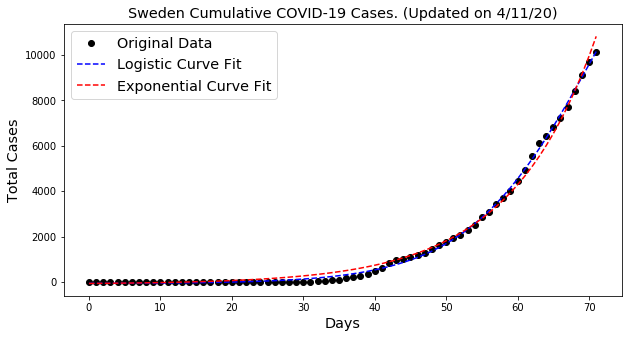



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 8928
	Confirmed cases on 4/4/20 	 4604
	Ratio: 1.94
	Weekly increase: 93.9 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.9929723276070046
	Doubling Time (during middle of growth):  12.88 (± 2.9 ) days
	param:  [ 2.36509622e+02  1.07643834e-01 -3.18382744e+02  3.10287647e+04]

** Based on Exponential Fit **

	R^2: 0.9862605275426078
	Doubling Time (represents overall growth):  6.45 (± 0.58 ) days
	param:  [100.           0.10752893 -84.75234189]


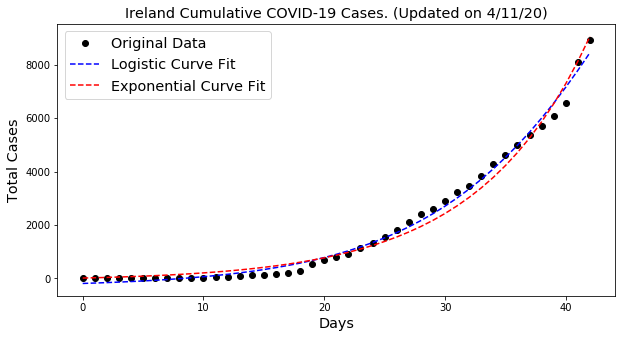



India

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 8446
	Confirmed cases on 4/4/20 	 3082
	Ratio: 2.74
	Weekly increase: 174.0 %
	Daily increase: 15.5 % per day
	Doubling Time (represents recent growth): 4.8 days

** Based on Logistic Fit**

	R^2: 0.9981689312658484
	Doubling Time (during middle of growth):  7.01 (± 0.4 ) days
	param:  [1.80329118e+06 1.97788164e-01 1.59085514e+01 1.84997367e+04]

** Based on Exponential Fit **

	R^2: 0.9956658835879075
	Doubling Time (represents overall growth):  4.7 (± 0.15 ) days
	param:  [  0.2168294    0.14754628 -28.01731709]


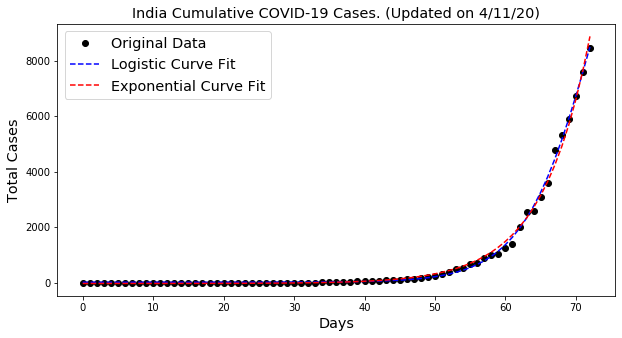



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 7257
	Confirmed cases on 4/4/20 	 3465
	Ratio: 2.09
	Weekly increase: 109.4 %
	Daily increase: 11.1 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9751509058638432
	Doubling Time (during middle of growth):  14.22 (± nan ) days
	param:  [ 5.47825986e+08  9.75069566e-02 -2.82904995e+02  7.22695178e+10]

** Based on Exponential Fit **

	R^2: 0.9735105739249174
	Doubling Time (represents overall growth):  6.53 (± 0.86 ) days
	param:  [  91.88511968    0.10608222 -100.        ]


/home/ma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning:

invalid value encountered in sqrt



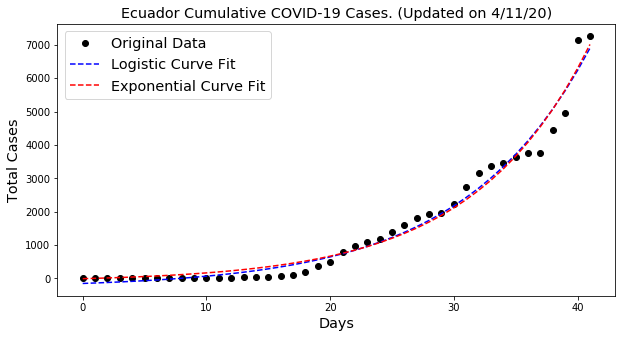



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 6927
	Confirmed cases on 4/4/20 	 4161
	Ratio: 1.66
	Weekly increase: 66.5 %
	Daily increase: 7.6 % per day
	Doubling Time (represents recent growth): 9.5 days

** Based on Logistic Fit**

	R^2: 0.9986532451628624
	Doubling Time (during middle of growth):  8.43 (± 0.6 ) days
	param:  [ 2.46217572e+02  1.64406170e-01 -1.25245887e+02  9.52778087e+03]

** Based on Exponential Fit **

	R^2: 0.9766821941585977
	Doubling Time (represents overall growth):  6.2 (± 0.78 ) days
	param:  [100.           0.11181916 -46.30206213]


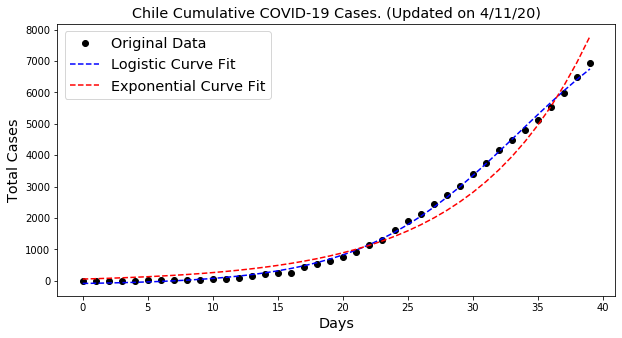



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 6848
	Confirmed cases on 4/4/20 	 1746
	Ratio: 3.92
	Weekly increase: 292.2 %
	Daily increase: 21.6 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.9925853862331238
	Doubling Time (during middle of growth):  7.61 (± 0.77 ) days
	param:  [8.67134663e+09 1.82259229e-01 6.74671196e+01 8.47227824e+10]

** Based on Exponential Fit **

	R^2: 0.9925853864827371
	Doubling Time (represents overall growth):  3.8 (± 0.24 ) days
	param:  [ 9.77043795  0.1822592  67.46702653]


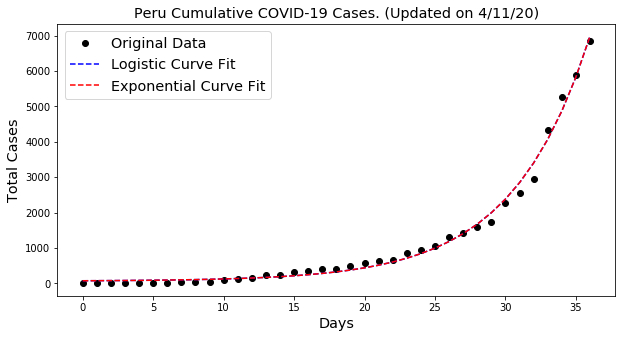



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 6409
	Confirmed cases on 4/4/20 	 5550
	Ratio: 1.15
	Weekly increase: 15.5 %
	Daily increase: 2.1 % per day
	Doubling Time (represents recent growth): 33.7 days

** Based on Logistic Fit**

	R^2: 0.9987452075625796
	Doubling Time (during middle of growth):  9.85 (± 0.58 ) days
	param:  [ 6.05508555e+01  1.40760415e-01 -2.08013318e+02  7.15904095e+03]

 exponential R^2  0.8055301216555493


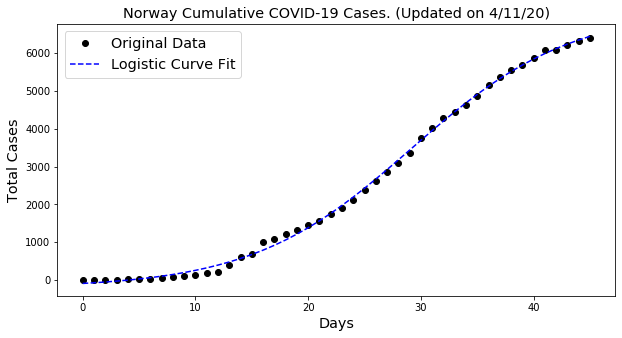



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 6356
	Confirmed cases on 4/4/20 	 3627
	Ratio: 1.75
	Weekly increase: 75.2 %
	Daily increase: 8.3 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.999693124355598
	Doubling Time (during middle of growth):  8.76 (± 0.32 ) days
	param:  [ 2.18468109e+02  1.58279317e-01 -8.90115351e+01  9.75909751e+03]

** Based on Exponential Fit **

	R^2: 0.9830786415398987
	Doubling Time (represents overall growth):  6.16 (± 0.67 ) days
	param:  [100.           0.11246991 -37.60612005]


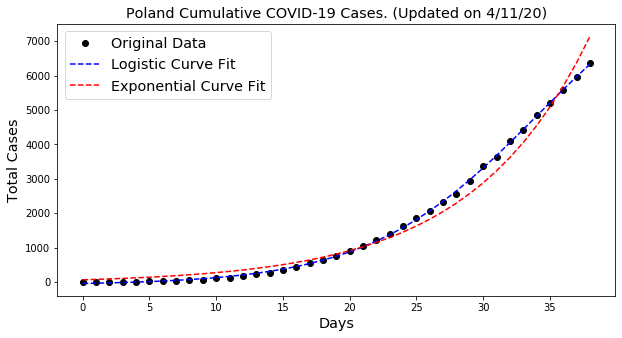



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 6303
	Confirmed cases on 4/4/20 	 5550
	Ratio: 1.14
	Weekly increase: 13.6 %
	Daily increase: 1.8 % per day
	Doubling Time (represents recent growth): 38.1 days

** Based on Logistic Fit**

	R^2: 0.9996495526476044
	Doubling Time (during middle of growth):  5.52 (± 0.11 ) days
	param:  [4.59516931e+06 2.51345475e-01 1.17173257e+01 6.32284978e+03]

 exponential R^2  0.9382654094355382


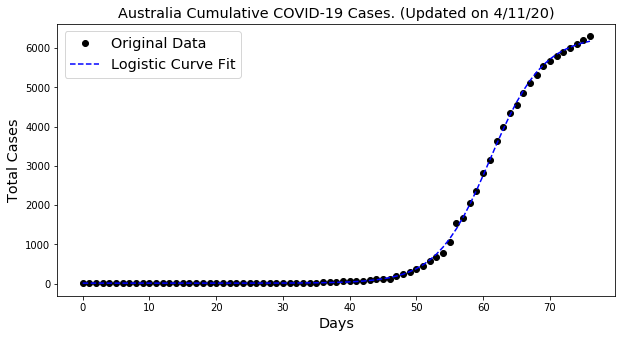



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 6191
	Confirmed cases on 4/4/20 	 4269
	Ratio: 1.45
	Weekly increase: 45.0 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 13.1 days

** Based on Logistic Fit**

	R^2: 0.9958033663373008
	Doubling Time (during middle of growth):  17.02 (± 3.61 ) days
	param:  [ 6.53843516e+01  8.14686947e-02 -3.87339837e+02  1.88303816e+04]

** Based on Exponential Fit **

	R^2: 0.9609159125740404
	Doubling Time (represents overall growth):  7.12 (± 1.07 ) days
	param:  [1.00000000e+02 9.74022372e-02 1.00000000e+02]


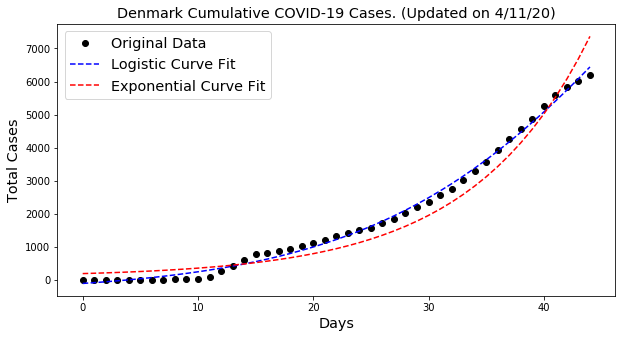



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 6005
	Confirmed cases on 4/4/20 	 3139
	Ratio: 1.91
	Weekly increase: 91.3 %
	Daily increase: 9.7 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.9921353970126787
	Doubling Time (during middle of growth):  15.81 (± 0.65 ) days
	param:  [5.54733355e+10 8.76865413e-02 6.49327268e+01 2.79539565e+11]

** Based on Exponential Fit **

	R^2: 0.9921353972598361
	Doubling Time (represents overall growth):  7.9 (± 0.34 ) days
	param:  [ 5.03925223  0.08768633 64.93136032]


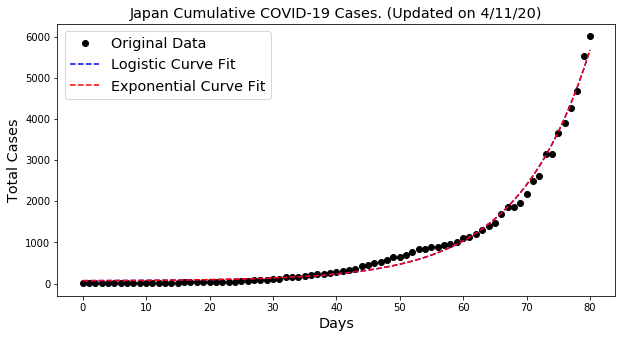



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 5990
	Confirmed cases on 4/4/20 	 3613
	Ratio: 1.66
	Weekly increase: 65.8 %
	Daily increase: 7.5 % per day
	Doubling Time (represents recent growth): 9.6 days

** Based on Logistic Fit**

	R^2: 0.998540011170737
	Doubling Time (during middle of growth):  7.89 (± 0.5 ) days
	param:  [ 1.01598595e+03  1.75811240e-01 -4.21603484e+01  7.98107615e+03]

** Based on Exponential Fit **

	R^2: 0.9859721696851891
	Doubling Time (represents overall growth):  6.84 (± 0.61 ) days
	param:  [  68.66046678    0.1012797  -100.        ]


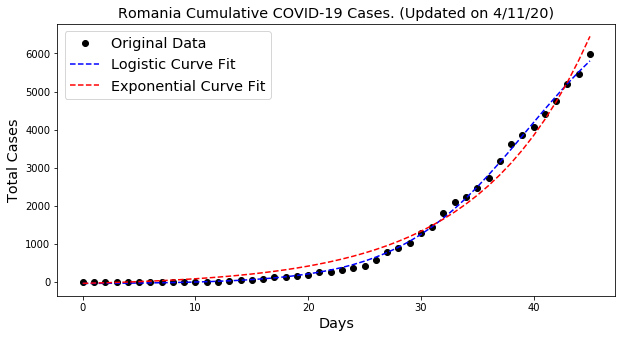



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 5831
	Confirmed cases on 4/4/20 	 4472
	Ratio: 1.3
	Weekly increase: 30.4 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.3 days

** Based on Logistic Fit**

	R^2: 0.9989720545900633
	Doubling Time (during middle of growth):  8.07 (± 0.44 ) days
	param:  [ 1.71880879e+02  1.71822887e-01 -1.04665171e+02  6.67760329e+03]

 exponential R^2  0.9272008715511305


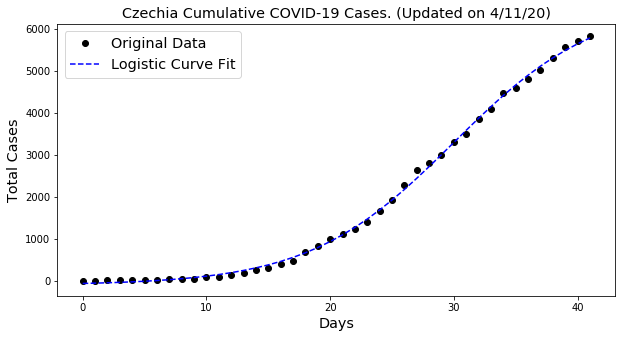



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 5011
	Confirmed cases on 4/4/20 	 2818
	Ratio: 1.78
	Weekly increase: 77.8 %
	Daily increase: 8.6 % per day
	Doubling Time (represents recent growth): 8.4 days

** Based on Logistic Fit**

	R^2: 0.9963024450790403
	Doubling Time (during middle of growth):  10.33 (± 1.22 ) days
	param:  [ 3.15141203e+02  1.34259753e-01 -9.55848528e+01  8.93608584e+03]

** Based on Exponential Fit **

	R^2: 0.9887420615087653
	Doubling Time (represents overall growth):  7.42 (± 0.62 ) days
	param:  [ 8.29858967e+01  9.34228832e-02 -1.00000000e+02]


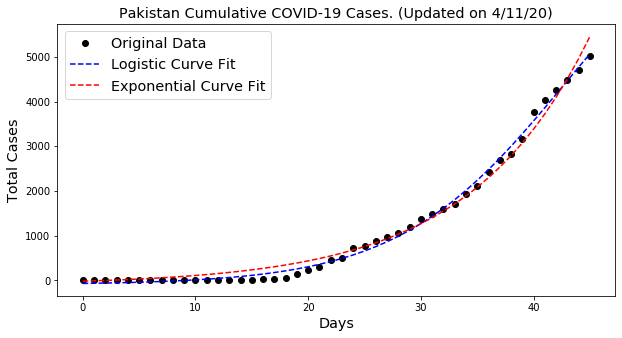



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 4530
	Confirmed cases on 4/4/20 	 3483
	Ratio: 1.3
	Weekly increase: 30.1 %
	Daily increase: 3.8 % per day
	Doubling Time (represents recent growth): 18.5 days

** Based on Logistic Fit**

	R^2: 0.9978733939138736
	Doubling Time (during middle of growth):  8.92 (± 0.46 ) days
	param:  [ 2.09099064e+04  1.55368757e-01 -1.47864453e+01  4.96699345e+03]

** Based on Exponential Fit **

	R^2: 0.9713541877064779
	Doubling Time (represents overall growth):  10.21 (± 0.94 ) days
	param:  [ 2.83074442e+01  6.79003573e-02 -1.00000000e+02]


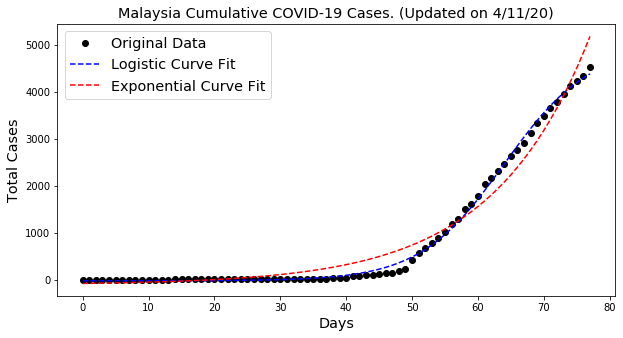



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 4428
	Confirmed cases on 4/4/20 	 3094
	Ratio: 1.43
	Weekly increase: 43.1 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.5 days

** Based on Logistic Fit**

	R^2: 0.9982451005288696
	Doubling Time (during middle of growth):  5.41 (± 0.26 ) days
	param:  [8.57264204e+06 2.56296256e-01 1.30579001e+01 4.67394698e+03]

** Based on Exponential Fit **

	R^2: 0.9670011939973638
	Doubling Time (represents overall growth):  7.29 (± 0.69 ) days
	param:  [ 5.53293409e+00  9.51269708e-02 -1.00000000e+02]


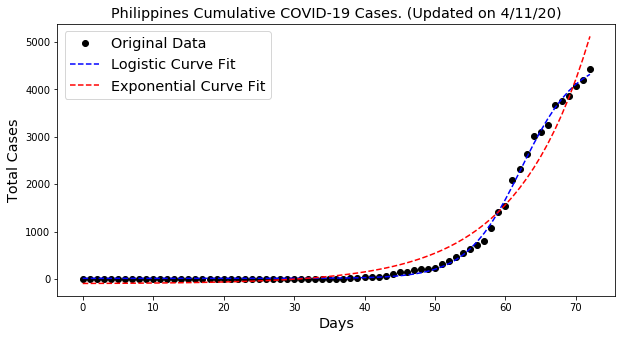



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 4033
	Confirmed cases on 4/4/20 	 2179
	Ratio: 1.85
	Weekly increase: 85.1 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9958015711217371
	Doubling Time (during middle of growth):  12.96 (± 2.37 ) days
	param:  [ 1.14994345e+02  1.06927507e-01 -1.77630642e+02  1.03392895e+04]

** Based on Exponential Fit **

	R^2: 0.9902569606291847
	Doubling Time (represents overall growth):  7.4 (± 0.64 ) days
	param:  [ 1.00000000e+02  9.36389593e-02 -1.00000000e+02]


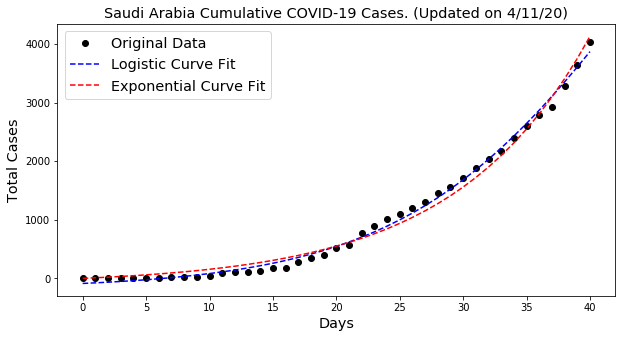



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 3844
	Confirmed cases on 4/4/20 	 1688
	Ratio: 2.28
	Weekly increase: 127.7 %
	Daily increase: 12.5 % per day
	Doubling Time (represents recent growth): 5.9 days

** Based on Logistic Fit**

	R^2: 0.9986495712574078
	Doubling Time (during middle of growth):  9.81 (± 0.77 ) days
	param:  [ 1.02417660e+03  1.41259202e-01 -4.64849745e+01  1.29749971e+04]

** Based on Exponential Fit **

	R^2: 0.9978461207137473
	Doubling Time (represents overall growth):  5.96 (± 0.2 ) days
	param:  [ 27.04962016   0.11627993 -88.92627236]


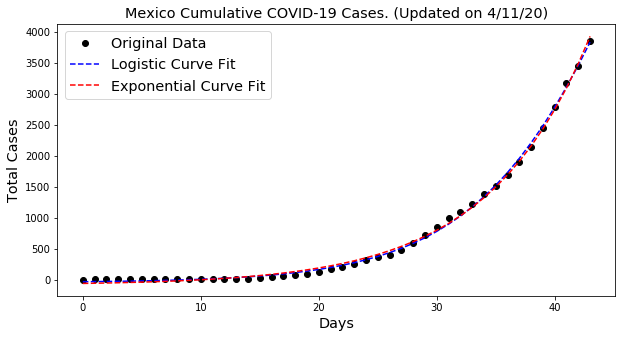



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 3842
	Confirmed cases on 4/4/20 	 2092
	Ratio: 1.84
	Weekly increase: 83.7 %
	Daily increase: 9.1 % per day
	Doubling Time (represents recent growth): 8.0 days

** Based on Logistic Fit**

	R^2: 0.9978022399822951
	Doubling Time (during middle of growth):  12.79 (± 1.67 ) days
	param:  [ 1.19604655e+02  1.08357441e-01 -1.58061980e+02  9.91388744e+03]

** Based on Exponential Fit **

	R^2: 0.992898172627842
	Doubling Time (represents overall growth):  7.47 (± 0.55 ) days
	param:  [ 1.00000000e+02  9.28403251e-02 -1.00000000e+02]


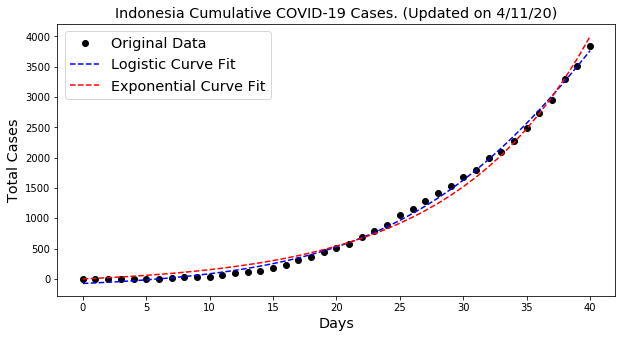



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 3736
	Confirmed cases on 4/4/20 	 1505
	Ratio: 2.48
	Weekly increase: 148.2 %
	Daily increase: 13.9 % per day
	Doubling Time (represents recent growth): 5.3 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9959962166379605
	Doubling Time (represents overall growth):  4.83 (± 0.15 ) days
	param:  [0.10975812 0.14362768 0.51506097]


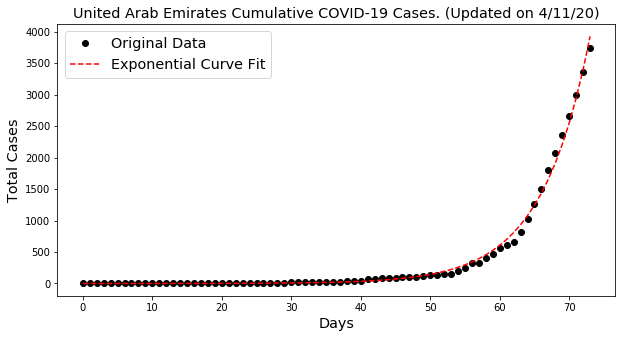



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 3380
	Confirmed cases on 4/4/20 	 1624
	Ratio: 2.08
	Weekly increase: 108.1 %
	Daily increase: 11.0 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9988706249608521
	Doubling Time (during middle of growth):  7.35 (± 0.5 ) days
	param:  [ 5.22389301e+02  1.88559707e-01 -6.39143384e+00  5.37696145e+03]

** Based on Exponential Fit **

	R^2: 0.9928443077025989
	Doubling Time (represents overall growth):  6.06 (± 0.45 ) days
	param:  [  60.30587456    0.11446096 -100.        ]


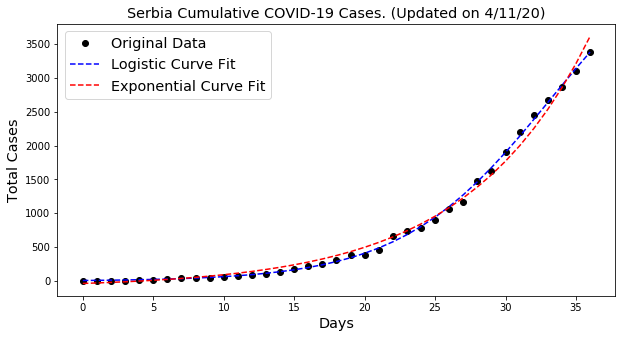



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 3270
	Confirmed cases on 4/4/20 	 2729
	Ratio: 1.2
	Weekly increase: 19.8 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 26.8 days

** Based on Logistic Fit**

	R^2: 0.9969289853993692
	Doubling Time (during middle of growth):  6.41 (± 0.52 ) days
	param:  [ 3.68031779e+02  2.16307748e-01 -6.84036854e+01  3.29154829e+03]

 exponential R^2  0.9020422508929128


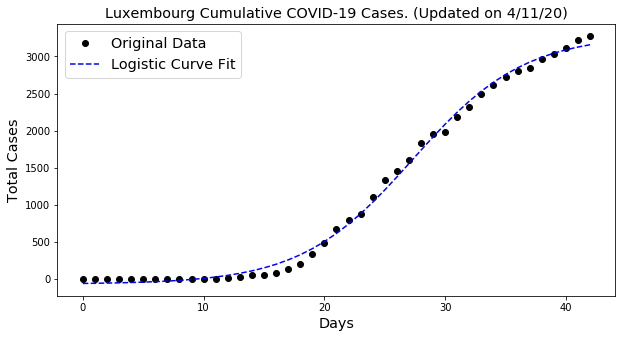



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 2974
	Confirmed cases on 4/4/20 	 1673
	Ratio: 1.78
	Weekly increase: 77.8 %
	Daily increase: 8.6 % per day
	Doubling Time (represents recent growth): 8.4 days

** Based on Logistic Fit**

	R^2: 0.9975908283800204
	Doubling Time (during middle of growth):  10.77 (± 1.69 ) days
	param:  [ 5.82227160e+01  1.28702134e-01 -1.47889371e+02  5.82222348e+03]

** Based on Exponential Fit **

	R^2: 0.98322361433825
	Doubling Time (represents overall growth):  6.37 (± 0.84 ) days
	param:  [100.           0.10884881 -40.86083432]


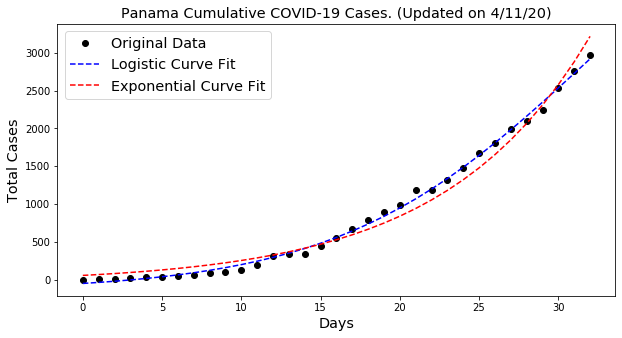



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 2905
	Confirmed cases on 4/4/20 	 1882
	Ratio: 1.54
	Weekly increase: 54.4 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.2 days

** Based on Logistic Fit**

	R^2: 0.9959959660803681
	Doubling Time (during middle of growth):  11.44 (± 0.94 ) days
	param:  [ 4.03245237e+03  1.21169883e-01 -2.76348466e+01  4.52984167e+03]

** Based on Exponential Fit **

	R^2: 0.9894651520967471
	Doubling Time (represents overall growth):  9.12 (± 0.5 ) days
	param:  [ 1.23675123e+01  7.60317249e-02 -8.45126035e+01]


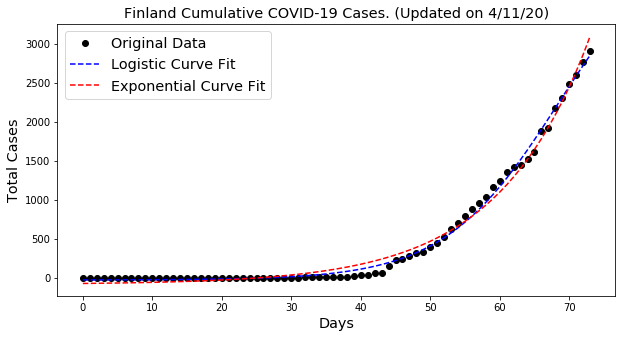



Dominican Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 2759
	Confirmed cases on 4/4/20 	 1488
	Ratio: 1.85
	Weekly increase: 85.4 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.9940742831996865
	Doubling Time (during middle of growth):  7.98 (± 1.1 ) days
	param:  [ 4.50964027e+02  1.73771003e-01 -5.23851666e+01  3.62941888e+03]

** Based on Exponential Fit **

	R^2: 0.982324218824114
	Doubling Time (represents overall growth):  7.07 (± 0.79 ) days
	param:  [ 5.47619229e+01  9.80440753e-02 -1.00000000e+02]


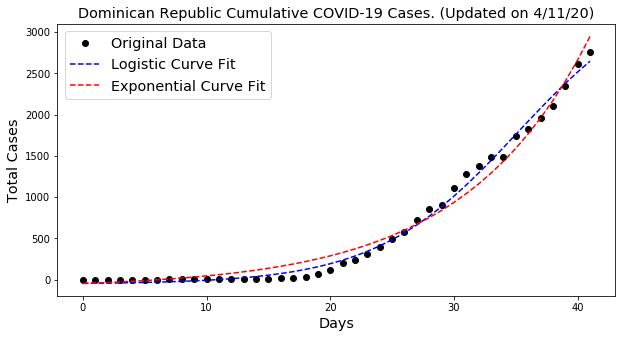



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 2728
	Confirmed cases on 4/4/20 	 1325
	Ratio: 2.06
	Weekly increase: 105.9 %
	Daily increase: 10.9 % per day
	Doubling Time (represents recent growth): 6.7 days

** Based on Logistic Fit**

	R^2: 0.9718036984119474
	Doubling Time (during middle of growth):  13.18 (± 2.47 ) days
	param:  [1.23918920e+09 1.05164529e-01 5.46259015e+01 4.14354829e+10]

** Based on Exponential Fit **

	R^2: 0.9718036987291796
	Doubling Time (represents overall growth):  6.59 (± 0.86 ) days
	param:  [33.43740548  0.10516465 54.62651674]


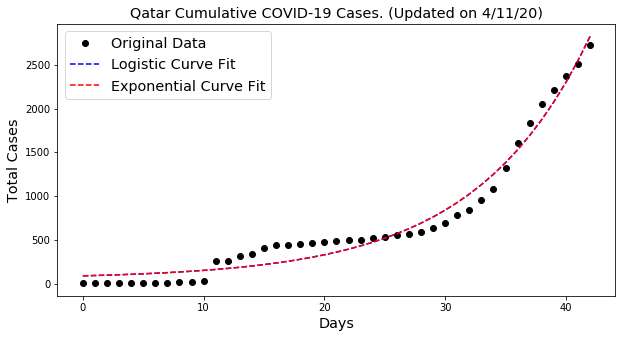



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 2709
	Confirmed cases on 4/4/20 	 1406
	Ratio: 1.93
	Weekly increase: 92.7 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9974116558215167
	Doubling Time (during middle of growth):  11.87 (± 1.87 ) days
	param:  [ 1.50824300e+02  1.16769648e-01 -1.08748695e+02  8.93092277e+03]

** Based on Exponential Fit **

	R^2: 0.9956033050083297
	Doubling Time (represents overall growth):  6.94 (± 0.43 ) days
	param:  [ 7.87918554e+01  9.98143617e-02 -1.00000000e+02]


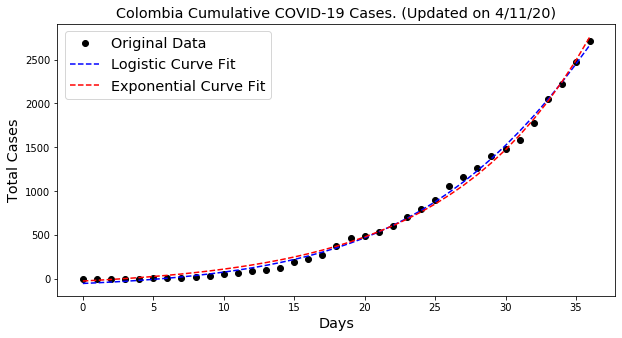



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 2518
	Confirmed cases on 4/4/20 	 2067
	Ratio: 1.22
	Weekly increase: 21.8 %
	Daily increase: 2.9 % per day
	Doubling Time (represents recent growth): 24.6 days

** Based on Logistic Fit**

	R^2: 0.9986311371354474
	Doubling Time (during middle of growth):  6.44 (± 0.25 ) days
	param:  [1.57738454e+06 2.15146436e-01 2.01773808e+01 2.59228276e+03]

** Based on Exponential Fit **

	R^2: 0.9570362838282205
	Doubling Time (represents overall growth):  9.81 (± 1.05 ) days
	param:  [ 1.07873934e+01  7.06625575e-02 -7.79320921e+01]


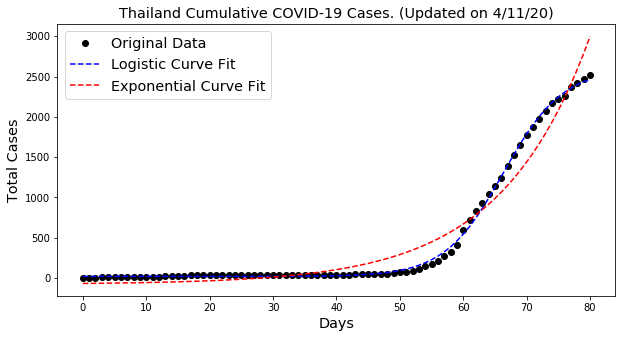



Ukraine

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 2511
	Confirmed cases on 4/4/20 	 1225
	Ratio: 2.05
	Weekly increase: 105.0 %
	Daily increase: 10.8 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.9921042584993842
	Doubling Time (during middle of growth):  8.13 (± 1.48 ) days
	param:  [ 7.43971453e+02  1.70447932e-01 -4.16581421e+01  4.72535052e+03]

** Based on Exponential Fit **

	R^2: 0.9891892768887242
	Doubling Time (represents overall growth):  5.87 (± 0.48 ) days
	param:  [ 25.99087241   0.11813269 -93.77713396]


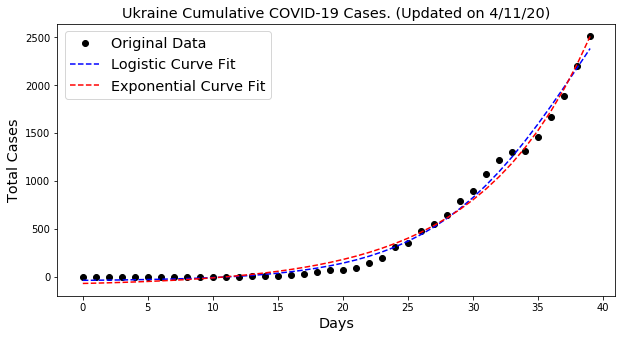



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 2299
	Confirmed cases on 4/4/20 	 1189
	Ratio: 1.93
	Weekly increase: 93.4 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9949299667085445
	Doubling Time (during middle of growth):  17.02 (± 0.38 ) days
	param:  [8.61185157e+09 8.14622139e-02 2.25275392e+01 3.00559716e+10]

** Based on Exponential Fit **

	R^2: 0.9949299669588317
	Doubling Time (represents overall growth):  8.51 (± 0.3 ) days
	param:  [ 3.49007099  0.08146221 22.52754619]


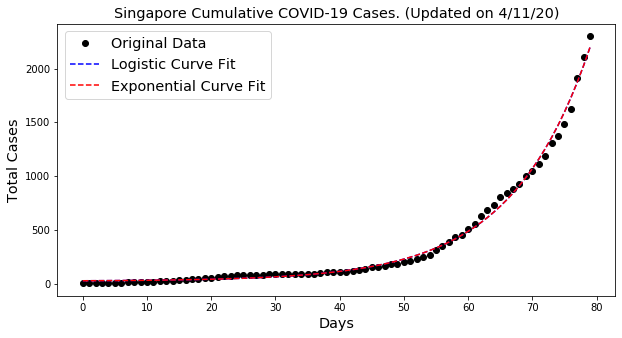



Belarus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 2226
	Confirmed cases on 4/4/20 	 440
	Ratio: 5.06
	Weekly increase: 405.9 %
	Daily increase: 26.1 % per day
	Doubling Time (represents recent growth): 3.0 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9946879095668278
	Doubling Time (represents overall growth):  2.86 (± 0.13 ) days
	param:  [ 0.06941807  0.2420836  20.36124717]


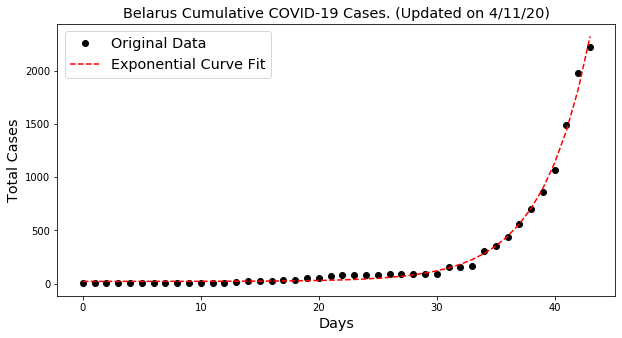



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 2081
	Confirmed cases on 4/4/20 	 1673
	Ratio: 1.24
	Weekly increase: 24.4 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 22.2 days

** Based on Logistic Fit**

	R^2: 0.9986322681737716
	Doubling Time (during middle of growth):  10.19 (± 0.66 ) days
	param:  [ 8.24555851e+01  1.35990667e-01 -5.02811477e+01  2.44367167e+03]

** Based on Exponential Fit **

	R^2: 0.9579118665035642
	Doubling Time (represents overall growth):  9.68 (± 1.81 ) days
	param:  [ 1.00000000e+02  7.16225612e-02 -4.49206867e+01]


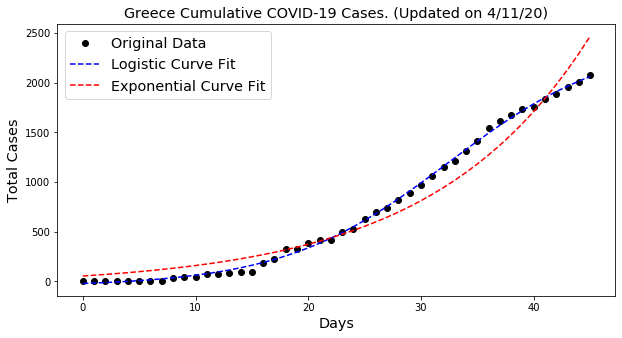



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 2028
	Confirmed cases on 4/4/20 	 1585
	Ratio: 1.28
	Weekly increase: 27.9 %
	Daily increase: 3.6 % per day
	Doubling Time (represents recent growth): 19.7 days

** Based on Logistic Fit**

	R^2: 0.9879411641366882
	Doubling Time (during middle of growth):  5.49 (± 0.94 ) days
	param:  [ 2.55939933e+02  2.52428750e-01 -4.01396089e+01  1.91723336e+03]

 exponential R^2  0.887160125449687


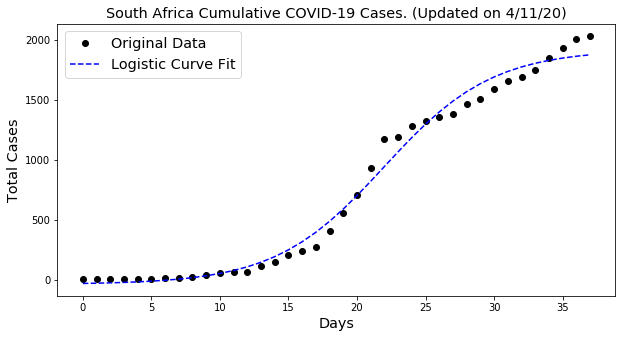



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1975
	Confirmed cases on 4/4/20 	 1451
	Ratio: 1.36
	Weekly increase: 36.1 %
	Daily increase: 4.5 % per day
	Doubling Time (represents recent growth): 15.7 days

** Based on Logistic Fit**

	R^2: 0.9974508682522348
	Doubling Time (during middle of growth):  7.3 (± 0.63 ) days
	param:  [ 2.76337474e+02  1.89833254e-01 -2.45532196e+01  2.28337787e+03]

** Based on Exponential Fit **

	R^2: 0.9731189313995346
	Doubling Time (represents overall growth):  8.3 (± 1.34 ) days
	param:  [ 9.05003204e+01  8.34915280e-02 -1.00000000e+02]


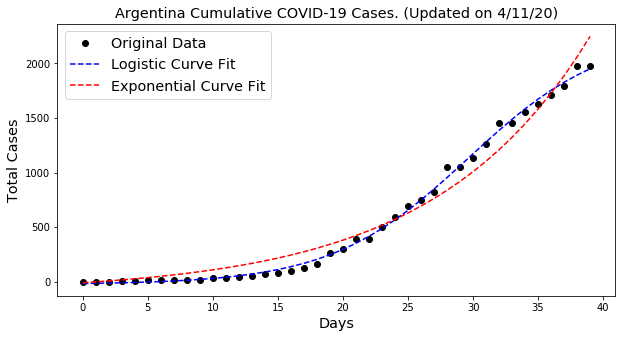



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1939
	Confirmed cases on 4/4/20 	 1070
	Ratio: 1.81
	Weekly increase: 81.2 %
	Daily increase: 8.9 % per day
	Doubling Time (represents recent growth): 8.2 days

** Based on Logistic Fit**

	R^2: 0.9980661121662054
	Doubling Time (during middle of growth):  13.67 (± 1.16 ) days
	param:  [ 9.95194395e+02  1.01377769e-01 -2.77385511e+01  8.07089997e+03]

** Based on Exponential Fit **

	R^2: 0.9975635611433271
	Doubling Time (represents overall growth):  8.0 (± 0.25 ) days
	param:  [ 14.65307411   0.08662604 -46.04101858]


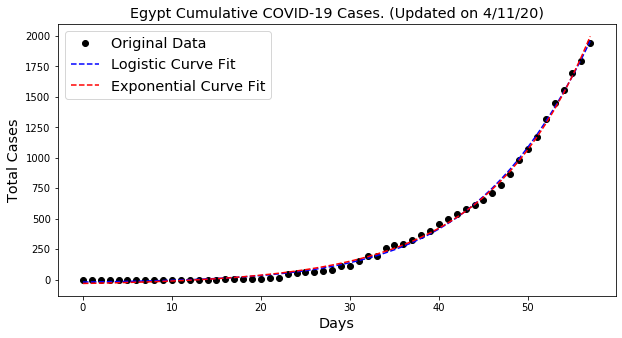



Algeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1825
	Confirmed cases on 4/4/20 	 1251
	Ratio: 1.46
	Weekly increase: 45.9 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 12.8 days

** Based on Logistic Fit**

	R^2: 0.9981502011741499
	Doubling Time (during middle of growth):  6.44 (± 0.41 ) days
	param:  [3.41269630e+03 2.15197866e-01 6.86153050e+00 2.12191950e+03]

** Based on Exponential Fit **

	R^2: 0.9787118344571453
	Doubling Time (represents overall growth):  7.81 (± 0.88 ) days
	param:  [ 3.61810040e+01  8.87629109e-02 -1.00000000e+02]


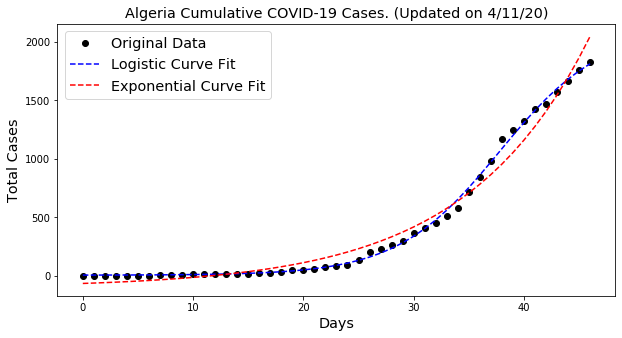



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1689
	Confirmed cases on 4/4/20 	 1417
	Ratio: 1.19
	Weekly increase: 19.2 %
	Daily increase: 2.5 % per day
	Doubling Time (represents recent growth): 27.6 days

** Based on Logistic Fit**

	R^2: 0.9990248637693728
	Doubling Time (during middle of growth):  8.33 (± 0.41 ) days
	param:  [ 1.16318398e+02  1.66438406e-01 -2.07200941e+01  1.85429004e+03]

 exponential R^2  0.9416281668521866


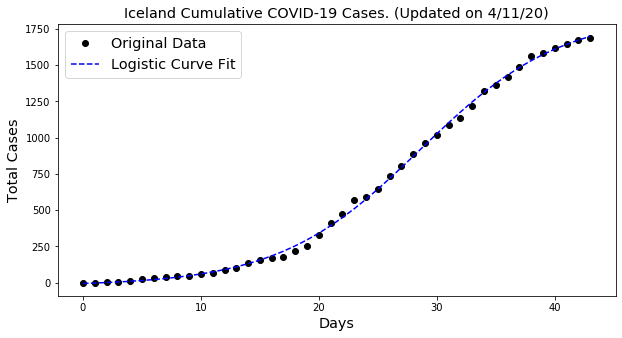



Moldova

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1560
	Confirmed cases on 4/4/20 	 752
	Ratio: 2.07
	Weekly increase: 107.4 %
	Daily increase: 11.0 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9985355399786288
	Doubling Time (during middle of growth):  6.91 (± 0.56 ) days
	param:  [5.73236646e+02 2.00682332e-01 4.45906428e+00 2.52635229e+03]

** Based on Exponential Fit **

	R^2: 0.993685980591914
	Doubling Time (represents overall growth):  5.85 (± 0.42 ) days
	param:  [ 30.30112092   0.11853263 -59.06795498]


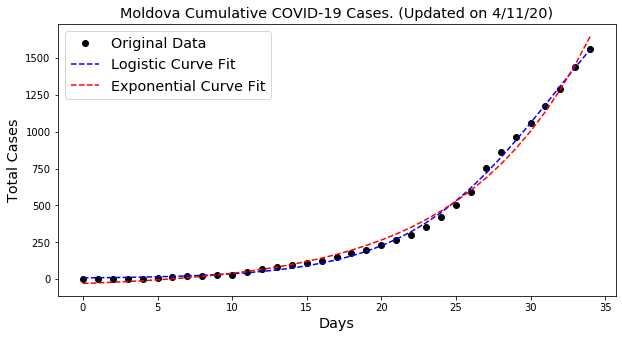



Morocco

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1545
	Confirmed cases on 4/4/20 	 919
	Ratio: 1.68
	Weekly increase: 68.1 %
	Daily increase: 7.7 % per day
	Doubling Time (represents recent growth): 9.3 days

** Based on Logistic Fit**

	R^2: 0.9985187698125816
	Doubling Time (during middle of growth):  7.7 (± 0.53 ) days
	param:  [ 4.52472646e+02  1.79985105e-01 -1.77298050e+01  2.04527710e+03]

** Based on Exponential Fit **

	R^2: 0.9880412381824129
	Doubling Time (represents overall growth):  7.68 (± 0.74 ) days
	param:  [ 4.78584095e+01  9.02691244e-02 -1.00000000e+02]


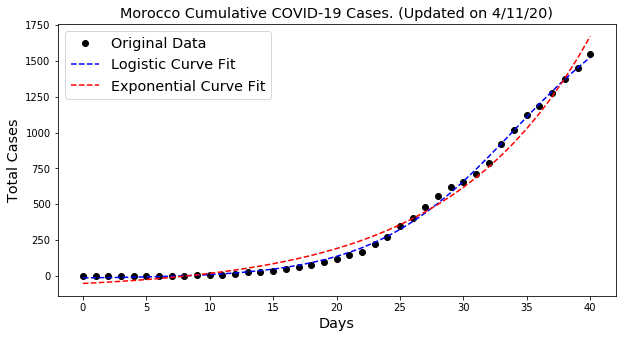



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1534
	Confirmed cases on 4/4/20 	 1126
	Ratio: 1.36
	Weekly increase: 36.2 %
	Daily increase: 4.5 % per day
	Doubling Time (represents recent growth): 15.7 days

** Based on Logistic Fit**

	R^2: 0.9975247975868089
	Doubling Time (during middle of growth):  7.07 (± 0.51 ) days
	param:  [ 8.28401013e+02  1.96076601e-01 -1.26119431e+01  1.61820464e+03]

** Based on Exponential Fit **

	R^2: 0.9679036200701013
	Doubling Time (represents overall growth):  9.51 (± 1.5 ) days
	param:  [ 6.42802242e+01  7.28963599e-02 -1.00000000e+02]


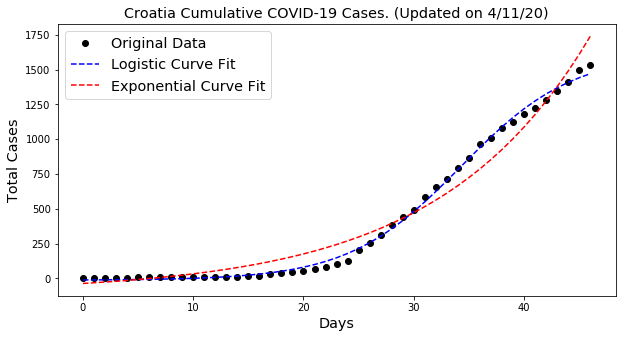



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1318
	Confirmed cases on 4/4/20 	 878
	Ratio: 1.5
	Weekly increase: 50.1 %
	Daily increase: 6.0 % per day
	Doubling Time (represents recent growth): 11.9 days

** Based on Logistic Fit**

	R^2: 0.9986915468338948
	Doubling Time (during middle of growth):  10.11 (± 0.64 ) days
	param:  [2.64214324e+02 1.37156366e-01 5.57562577e+00 1.89733204e+03]

** Based on Exponential Fit **

	R^2: 0.9915261553925407
	Doubling Time (represents overall growth):  10.06 (± 0.8 ) days
	param:  [ 5.99808554e+01  6.89014581e-02 -9.19182187e+01]


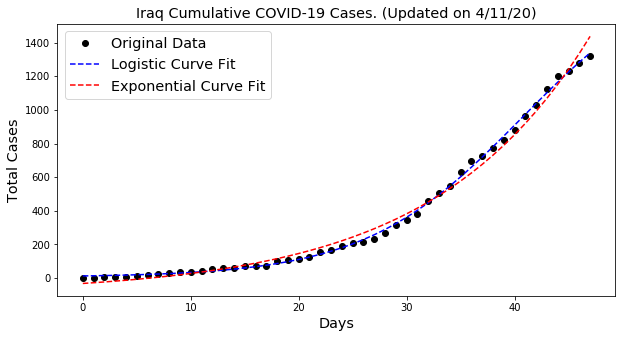



New Zealand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1312
	Confirmed cases on 4/4/20 	 950
	Ratio: 1.38
	Weekly increase: 38.1 %
	Daily increase: 4.7 % per day
	Doubling Time (represents recent growth): 15.0 days

** Based on Logistic Fit**

	R^2: 0.9982601967340453
	Doubling Time (during middle of growth):  5.59 (± 0.34 ) days
	param:  [ 3.20633449e+03  2.47785666e-01 -9.20675931e+00  1.39662593e+03]

** Based on Exponential Fit **

	R^2: 0.9621119946064138
	Doubling Time (represents overall growth):  8.33 (± 1.42 ) days
	param:  [ 4.57458540e+01  8.32278832e-02 -1.00000000e+02]


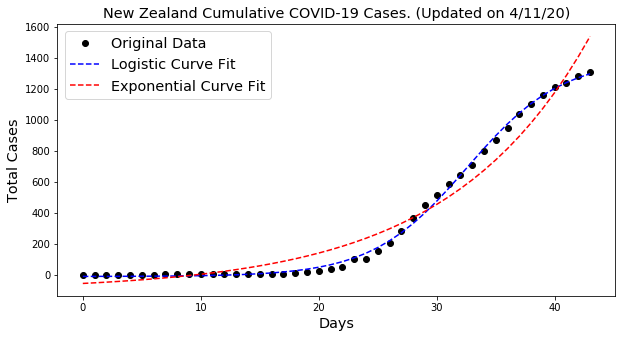



Hungary

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1310
	Confirmed cases on 4/4/20 	 678
	Ratio: 1.93
	Weekly increase: 93.2 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9918820466154336
	Doubling Time (during middle of growth):  14.75 (± 4.92 ) days
	param:  [ 2.19429532e+02  9.40074305e-02 -7.04184097e+01  9.37536615e+03]

** Based on Exponential Fit **

	R^2: 0.9918022031197712
	Doubling Time (represents overall growth):  8.16 (± 0.71 ) days
	param:  [ 53.31764225   0.08491826 -84.89420051]


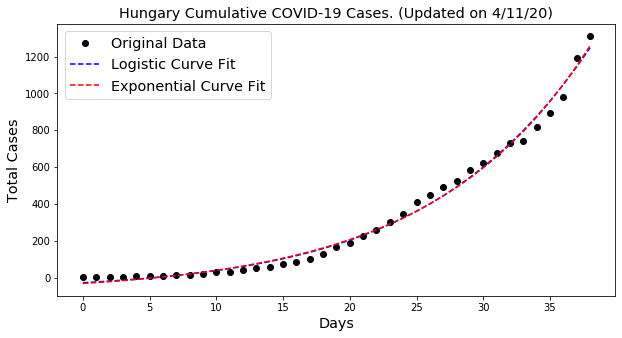



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1304
	Confirmed cases on 4/4/20 	 1039
	Ratio: 1.26
	Weekly increase: 25.5 %
	Daily increase: 3.3 % per day
	Doubling Time (represents recent growth): 21.4 days

** Based on Logistic Fit**

	R^2: 0.9951051033306328
	Doubling Time (during middle of growth):  10.46 (± 1.35 ) days
	param:  [ 8.27925301e+01  1.32470457e-01 -4.10848982e+01  1.63374394e+03]

** Based on Exponential Fit **

	R^2: 0.9752729863650305
	Doubling Time (represents overall growth):  11.0 (± 1.77 ) days
	param:  [ 9.83679049e+01  6.30391076e-02 -1.00000000e+02]


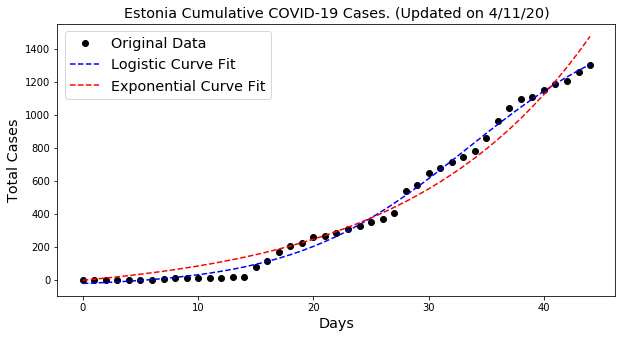



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1188
	Confirmed cases on 4/4/20 	 977
	Ratio: 1.22
	Weekly increase: 21.6 %
	Daily increase: 2.8 % per day
	Doubling Time (represents recent growth): 24.8 days

** Based on Logistic Fit**

	R^2: 0.9979400761560542
	Doubling Time (during middle of growth):  13.23 (± 1.78 ) days
	param:  [ 1.10143734e+01  1.04754472e-01 -1.56180886e+02  1.49129306e+03]

 exponential R^2  0.9262642048088674


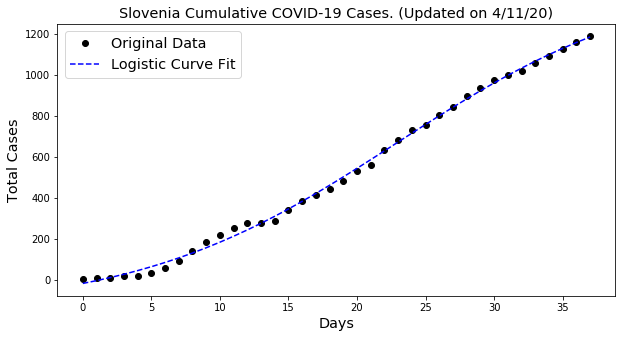



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1154
	Confirmed cases on 4/4/20 	 479
	Ratio: 2.41
	Weekly increase: 140.9 %
	Daily increase: 13.4 % per day
	Doubling Time (represents recent growth): 5.5 days

** Based on Logistic Fit**

	R^2: 0.9902151360614392
	Doubling Time (during middle of growth):  11.01 (± nan ) days
	param:  [7.23709678e+09 1.25933509e-01 5.24782449e+01 2.13145111e+10]

** Based on Exponential Fit **

	R^2: 0.990215136314578
	Doubling Time (represents overall growth):  5.5 (± 0.36 ) days
	param:  [ 2.94520957  0.12593324 52.47795544]


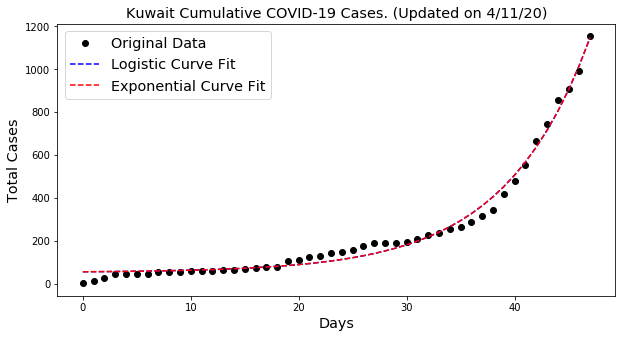



Azerbaijan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1058
	Confirmed cases on 4/4/20 	 521
	Ratio: 2.03
	Weekly increase: 103.1 %
	Daily increase: 10.6 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.9991480198260707
	Doubling Time (during middle of growth):  7.67 (± 0.42 ) days
	param:  [1.19574183e+03 1.80693094e-01 8.40387458e-01 1.83960886e+03]

** Based on Exponential Fit **

	R^2: 0.9944889420875033
	Doubling Time (represents overall growth):  6.02 (± 0.34 ) days
	param:  [ 10.31790269   0.11511192 -27.73499457]


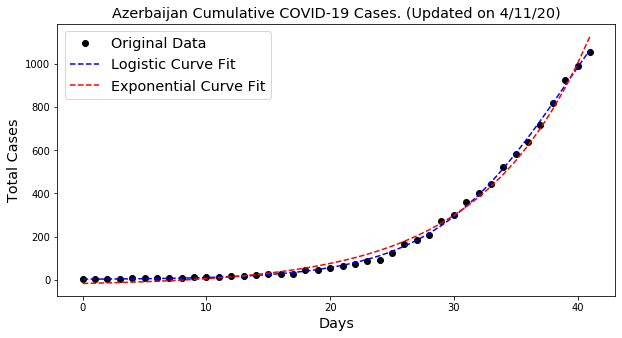



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1040
	Confirmed cases on 4/4/20 	 688
	Ratio: 1.51
	Weekly increase: 51.2 %
	Daily increase: 6.1 % per day
	Doubling Time (represents recent growth): 11.7 days

** Based on Logistic Fit**

	R^2: 0.995145060257738
	Doubling Time (during middle of growth):  33.0 (± 19.76 ) days
	param:  [ 2.31236929e+06  4.20141742e-02 -1.61573572e+02  3.68678123e+08]

** Based on Exponential Fit **

	R^2: 0.9927047135540802
	Doubling Time (represents overall growth):  13.62 (± 1.24 ) days
	param:  [ 1.00000000e+02  5.08940923e-02 -7.66057551e+01]


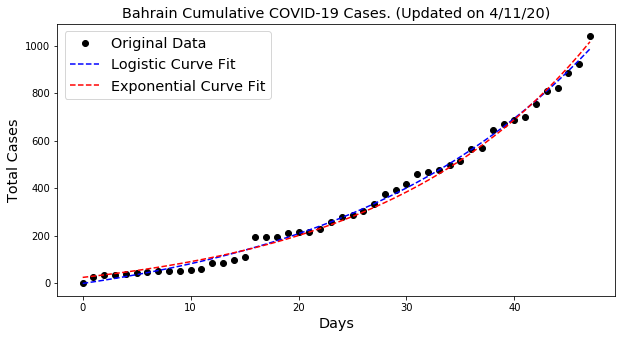



Lithuania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 1026
	Confirmed cases on 4/4/20 	 771
	Ratio: 1.33
	Weekly increase: 33.1 %
	Daily increase: 4.2 % per day
	Doubling Time (represents recent growth): 17.0 days

** Based on Logistic Fit**

	R^2: 0.997470522232807
	Doubling Time (during middle of growth):  6.73 (± 0.51 ) days
	param:  [ 7.27931790e+02  2.06025648e-01 -1.45978619e+01  1.10696370e+03]

** Based on Exponential Fit **

	R^2: 0.9690455044872235
	Doubling Time (represents overall growth):  9.51 (± 1.58 ) days
	param:  [ 5.53026103e+01  7.29100425e-02 -1.00000000e+02]


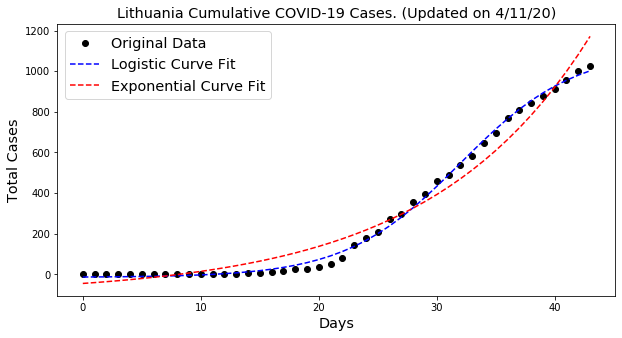



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 967
	Confirmed cases on 4/4/20 	 770
	Ratio: 1.26
	Weekly increase: 25.6 %
	Daily increase: 3.3 % per day
	Doubling Time (represents recent growth): 21.3 days

** Based on Logistic Fit**

	R^2: 0.9974684505921878
	Doubling Time (during middle of growth):  7.53 (± 0.62 ) days
	param:  [ 2.41342154e+02  1.84023011e-01 -1.31066447e+01  1.09606951e+03]

** Based on Exponential Fit **

	R^2: 0.9710152068767627
	Doubling Time (represents overall growth):  10.23 (± 1.84 ) days
	param:  [ 7.57122789e+01  6.77746490e-02 -1.00000000e+02]


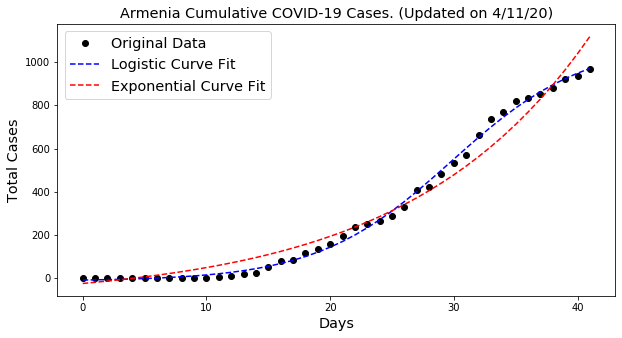



Bosnia and Herzegovina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 946
	Confirmed cases on 4/4/20 	 624
	Ratio: 1.52
	Weekly increase: 51.6 %
	Daily increase: 6.1 % per day
	Doubling Time (represents recent growth): 11.7 days

** Based on Logistic Fit**

	R^2: 0.998436203995819
	Doubling Time (during middle of growth):  8.0 (± 0.61 ) days
	param:  [ 1.68655768e+02  1.73295834e-01 -1.24598193e+01  1.19579062e+03]

** Based on Exponential Fit **

	R^2: 0.987586957469488
	Doubling Time (represents overall growth):  9.1 (± 1.09 ) days
	param:  [ 6.70800152e+01  7.62118127e-02 -1.00000000e+02]


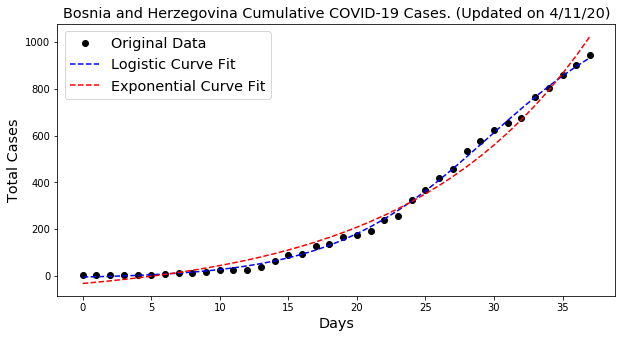



Kazakhstan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 865
	Confirmed cases on 4/4/20 	 531
	Ratio: 1.63
	Weekly increase: 62.9 %
	Daily increase: 7.2 % per day
	Doubling Time (represents recent growth): 9.9 days

** Based on Logistic Fit**

	R^2: 0.9965891886831174
	Doubling Time (during middle of growth):  6.46 (± 0.82 ) days
	param:  [ 9.70350166e+01  2.14437595e-01 -6.04890595e+00  1.01516303e+03]

** Based on Exponential Fit **

	R^2: 0.9803197206906301
	Doubling Time (represents overall growth):  8.25 (± 1.59 ) days
	param:  [ 9.18643663e+01  8.39840348e-02 -1.00000000e+02]


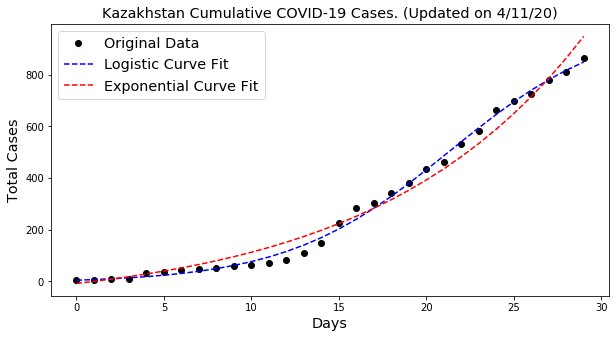



Cameroon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 820
	Confirmed cases on 4/4/20 	 555
	Ratio: 1.48
	Weekly increase: 47.7 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.4 days

** Based on Logistic Fit**

	R^2: 0.990378020612839
	Doubling Time (during middle of growth):  3.39 (± 0.53 ) days
	param:  [8.30623780e+04 4.08601832e-01 1.44496853e+01 8.28699372e+02]

 exponential R^2  0.9497035142774621


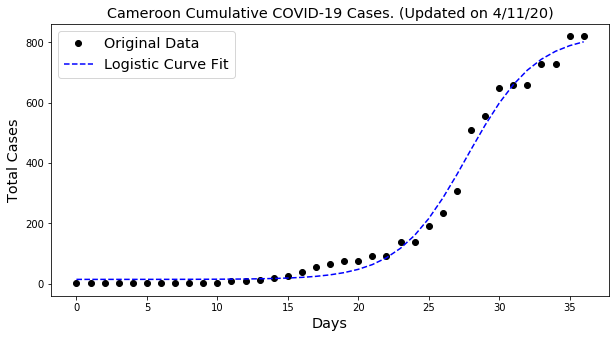



Uzbekistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 767
	Confirmed cases on 4/4/20 	 266
	Ratio: 2.88
	Weekly increase: 188.3 %
	Daily increase: 16.3 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Logistic Fit**

	R^2: 0.9898777767795154
	Doubling Time (during middle of growth):  7.35 (± 2.18 ) days
	param:  [1.81898999e+02 1.88669234e-01 5.21213004e+00 1.56716989e+03]

** Based on Exponential Fit **

	R^2: 0.9881373319521904
	Doubling Time (represents overall growth):  5.51 (± 0.67 ) days
	param:  [ 26.49977456   0.12585534 -25.93357802]


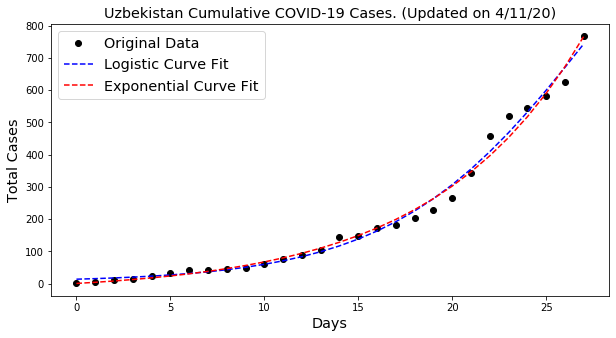



North Macedonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 760
	Confirmed cases on 4/4/20 	 483
	Ratio: 1.57
	Weekly increase: 57.3 %
	Daily increase: 6.7 % per day
	Doubling Time (represents recent growth): 10.7 days

** Based on Logistic Fit**

	R^2: 0.997254019222808
	Doubling Time (during middle of growth):  8.96 (± 0.81 ) days
	param:  [ 3.90753629e+02  1.54638322e-01 -1.07858708e+01  1.02273271e+03]

** Based on Exponential Fit **

	R^2: 0.9879491307202499
	Doubling Time (represents overall growth):  8.95 (± 0.83 ) days
	param:  [ 26.55427005   0.07745043 -58.64932082]


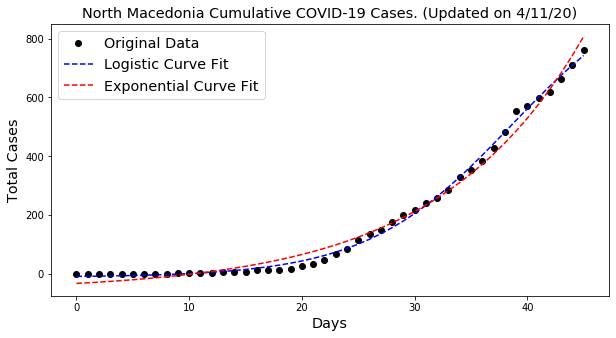



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 728
	Confirmed cases on 4/4/20 	 471
	Ratio: 1.55
	Weekly increase: 54.6 %
	Daily increase: 6.4 % per day
	Doubling Time (represents recent growth): 11.1 days

** Based on Logistic Fit**

	R^2: 0.9948821645717105
	Doubling Time (during middle of growth):  21.32 (± 10.29 ) days
	param:  [ 3.37863717e+01  6.50120415e-02 -1.25409752e+02  3.61855815e+03]

** Based on Exponential Fit **

	R^2: 0.9927343730001342
	Doubling Time (represents overall growth):  11.46 (± 1.29 ) days
	param:  [ 9.95894531e+01  6.04871863e-02 -1.00000000e+02]


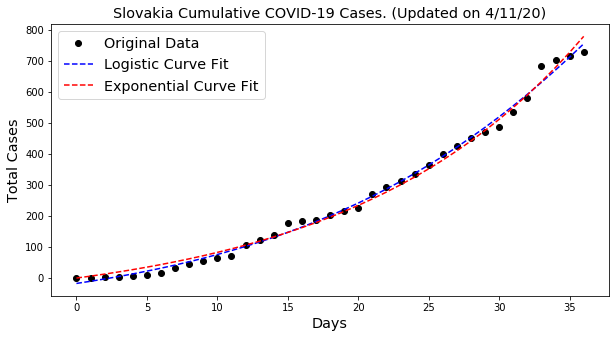



Diamond Princess

** Based on Logistic Fit**

	R^2: 0.9963304523455041
	Doubling Time (during middle of growth):  2.82 (± 0.22 ) days
	param:  [8.95427246e+01 4.90725043e-01 6.85748890e+01 7.08788951e+02]

 exponential R^2  -0.6420253772771343


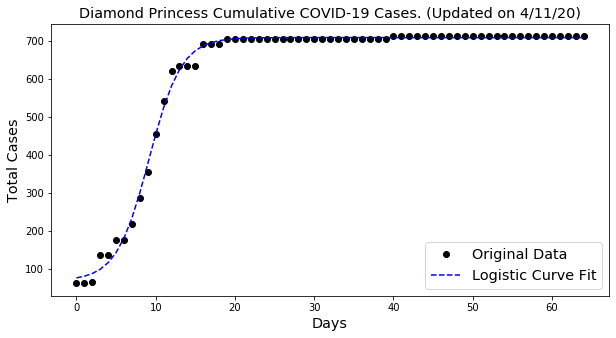



Tunisia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 685
	Confirmed cases on 4/4/20 	 553
	Ratio: 1.24
	Weekly increase: 23.9 %
	Daily increase: 3.1 % per day
	Doubling Time (represents recent growth): 22.7 days

** Based on Logistic Fit**

	R^2: 0.9985010827606381
	Doubling Time (during middle of growth):  5.83 (± 0.36 ) days
	param:  [ 5.29945245e+02  2.37644939e-01 -2.06064109e+00  7.20094624e+02]

** Based on Exponential Fit **

	R^2: 0.9629464672393921
	Doubling Time (represents overall growth):  10.35 (± 2.32 ) days
	param:  [ 7.04545361e+01  6.69605441e-02 -1.00000000e+02]


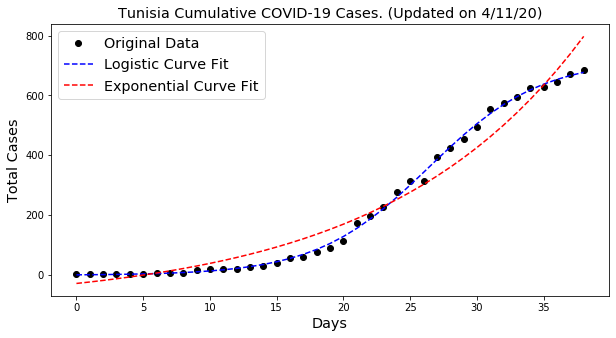



Bulgaria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 661
	Confirmed cases on 4/4/20 	 503
	Ratio: 1.31
	Weekly increase: 31.4 %
	Daily increase: 4.0 % per day
	Doubling Time (represents recent growth): 17.8 days

** Based on Logistic Fit**

	R^2: 0.9986419511575062
	Doubling Time (during middle of growth):  11.0 (± 1.11 ) days
	param:  [ 1.60478181e+01  1.25991210e-01 -6.30500257e+01  8.10947508e+02]

** Based on Exponential Fit **

	R^2: 0.9655416413694763
	Doubling Time (represents overall growth):  11.17 (± 2.95 ) days
	param:  [ 1.00000000e+02  6.20697655e-02 -7.26237778e+01]


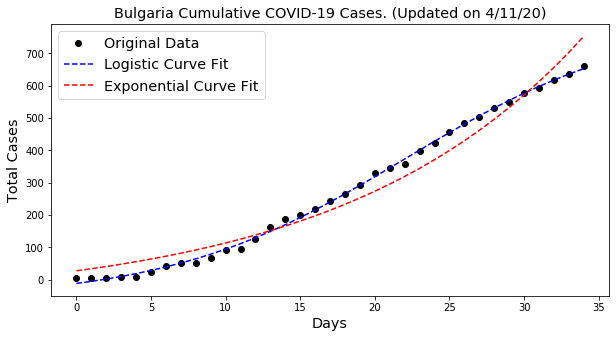



Latvia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 630
	Confirmed cases on 4/4/20 	 509
	Ratio: 1.24
	Weekly increase: 23.8 %
	Daily increase: 3.1 % per day
	Doubling Time (represents recent growth): 22.8 days

** Based on Logistic Fit**

	R^2: 0.9989826839645529
	Doubling Time (during middle of growth):  7.33 (± 0.38 ) days
	param:  [ 1.48479929e+02  1.89169282e-01 -1.13246015e+01  6.61217373e+02]

** Based on Exponential Fit **

	R^2: 0.9655217831408883
	Doubling Time (represents overall growth):  12.22 (± 2.83 ) days
	param:  [ 8.51199444e+01  5.67347503e-02 -1.00000000e+02]


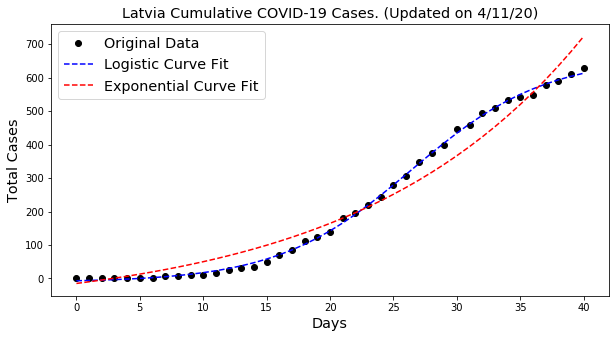



Cuba

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 620
	Confirmed cases on 4/4/20 	 288
	Ratio: 2.15
	Weekly increase: 115.3 %
	Daily increase: 11.6 % per day
	Doubling Time (represents recent growth): 6.3 days

** Based on Logistic Fit**

	R^2: 0.9970992111697325
	Doubling Time (during middle of growth):  10.21 (± 1.91 ) days
	param:  [ 1.08520845e+02  1.35740580e-01 -2.54950576e+01  1.80327697e+03]

** Based on Exponential Fit **

	R^2: 0.9963057893494295
	Doubling Time (represents overall growth):  6.83 (± 0.47 ) days
	param:  [ 32.22627998   0.10153594 -47.56817324]


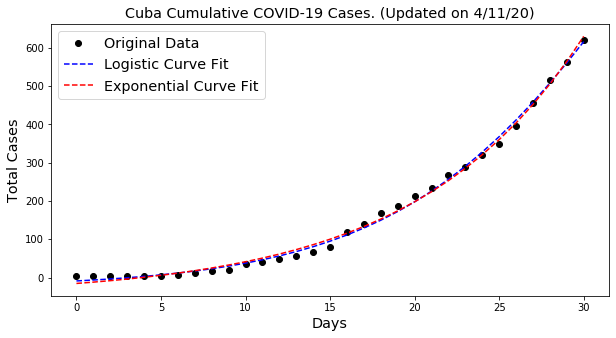



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 619
	Confirmed cases on 4/4/20 	 520
	Ratio: 1.19
	Weekly increase: 19.0 %
	Daily increase: 2.5 % per day
	Doubling Time (represents recent growth): 27.8 days

** Based on Logistic Fit**

	R^2: 0.9971240754523447
	Doubling Time (during middle of growth):  7.81 (± 0.56 ) days
	param:  [ 3.16617456e+02  1.77397051e-01 -1.83876387e+00  6.16657729e+02]

** Based on Exponential Fit **

	R^2: 0.9572147011179324
	Doubling Time (represents overall growth):  15.22 (± 3.51 ) days
	param:  [ 8.34554132e+01  4.55379449e-02 -1.00000000e+02]


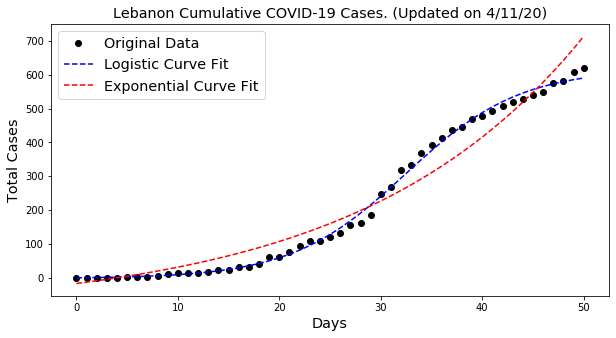



Cyprus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 616
	Confirmed cases on 4/4/20 	 426
	Ratio: 1.45
	Weekly increase: 44.6 %
	Daily increase: 5.4 % per day
	Doubling Time (represents recent growth): 13.2 days

** Based on Logistic Fit**

	R^2: 0.9971591531470881
	Doubling Time (during middle of growth):  8.69 (± 1.09 ) days
	param:  [ 6.34149132e+01  1.59452218e-01 -5.58606880e+00  8.21583835e+02]

** Based on Exponential Fit **

	R^2: 0.9901976990840763
	Doubling Time (represents overall growth):  10.58 (± 1.45 ) days
	param:  [ 8.75946396e+01  6.55331647e-02 -1.00000000e+02]


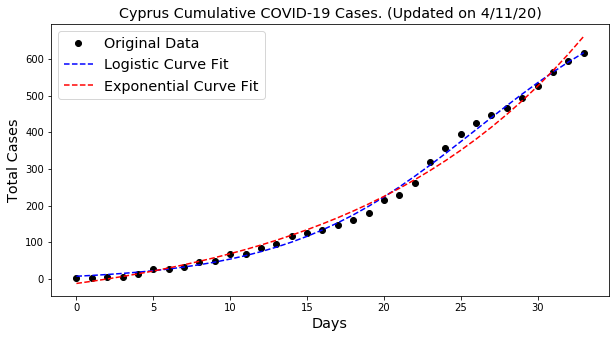



Andorra

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 601
	Confirmed cases on 4/4/20 	 466
	Ratio: 1.29
	Weekly increase: 29.0 %
	Daily increase: 3.7 % per day
	Doubling Time (represents recent growth): 19.1 days

** Based on Logistic Fit**

	R^2: 0.9964223943019194
	Doubling Time (during middle of growth):  6.76 (± 0.63 ) days
	param:  [ 2.44981387e+02  2.05054542e-01 -1.39896708e+01  6.31861150e+02]

** Based on Exponential Fit **

	R^2: 0.9620996405074691
	Doubling Time (represents overall growth):  11.61 (± 2.7 ) days
	param:  [ 7.37436409e+01  5.97024297e-02 -1.00000000e+02]


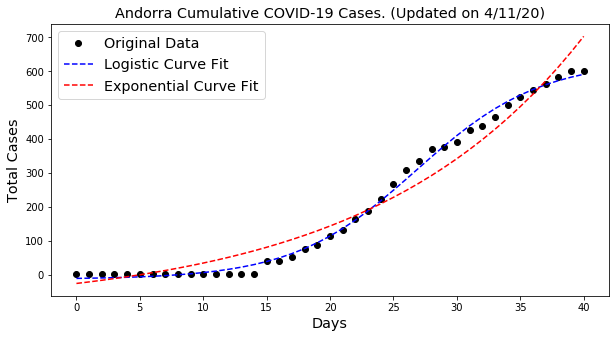



Costa Rica

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 577
	Confirmed cases on 4/4/20 	 435
	Ratio: 1.33
	Weekly increase: 32.6 %
	Daily increase: 4.1 % per day
	Doubling Time (represents recent growth): 17.2 days

** Based on Logistic Fit**

	R^2: 0.9966443248576345
	Doubling Time (during middle of growth):  8.52 (± 0.97 ) days
	param:  [ 4.23635784e+01  1.62791552e-01 -2.26264396e+01  6.21975936e+02]

** Based on Exponential Fit **

	R^2: 0.9706659472757776
	Doubling Time (represents overall growth):  12.45 (± 3.08 ) days
	param:  [ 1.00000000e+02  5.56868167e-02 -1.00000000e+02]


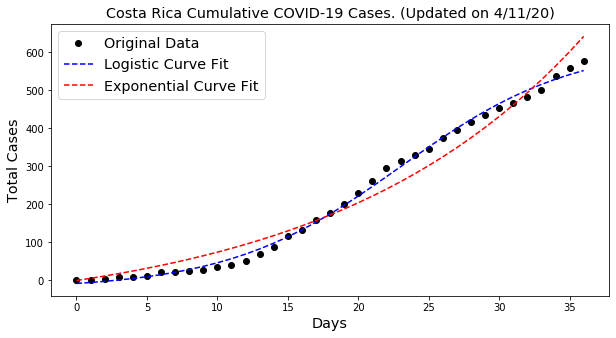



Afghanistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 555
	Confirmed cases on 4/4/20 	 299
	Ratio: 1.86
	Weekly increase: 85.6 %
	Daily increase: 9.2 % per day
	Doubling Time (represents recent growth): 7.8 days

** Based on Logistic Fit**

	R^2: 0.9973384137648841
	Doubling Time (during middle of growth):  7.51 (± 0.62 ) days
	param:  [ 2.37330832e+03  1.84704768e-01 -4.81220446e-01  7.70185103e+02]

** Based on Exponential Fit **

	R^2: 0.9882212860768769
	Doubling Time (represents overall growth):  6.88 (± 0.53 ) days
	param:  [  5.42562117   0.10071568 -19.37475545]


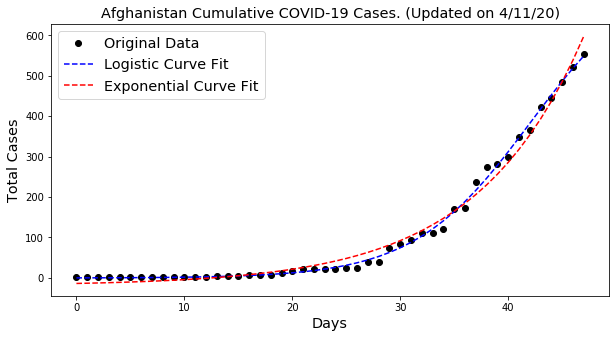



Oman

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 546
	Confirmed cases on 4/4/20 	 277
	Ratio: 1.97
	Weekly increase: 97.1 %
	Daily increase: 10.2 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9974446410851823
	Doubling Time (during middle of growth):  11.59 (± 1.25 ) days
	param:  [ 6.06478314e+02  1.19595013e-01 -7.36198177e-01  1.71506183e+03]

** Based on Exponential Fit **

	R^2: 0.9966418313227355
	Doubling Time (represents overall growth):  7.16 (± 0.3 ) days
	param:  [ 5.90075245  0.09679187 -8.16700664]


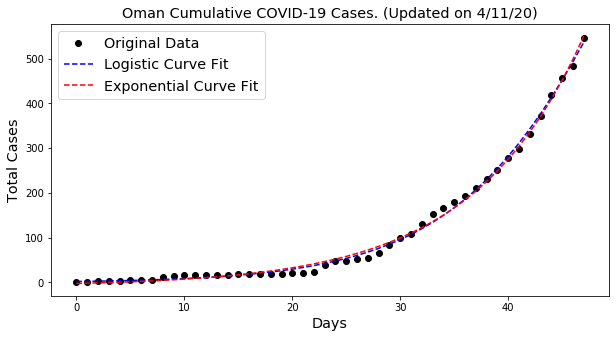



Cote d'Ivoire

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 533
	Confirmed cases on 4/4/20 	 245
	Ratio: 2.18
	Weekly increase: 117.6 %
	Daily increase: 11.7 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9892842349817337
	Doubling Time (during middle of growth):  13.86 (± 7.06 ) days
	param:  [ 1.35959510e+02  1.00021130e-01 -4.41203803e+01  3.94921608e+03]

** Based on Exponential Fit **

	R^2: 0.9892093290047711
	Doubling Time (represents overall growth):  7.76 (± 0.95 ) days
	param:  [ 35.94030999   0.08932091 -52.64509192]


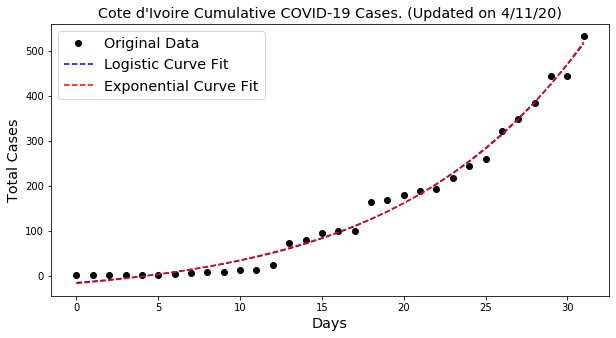



Uruguay

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 494
	Confirmed cases on 4/4/20 	 400
	Ratio: 1.24
	Weekly increase: 23.5 %
	Daily increase: 3.1 % per day
	Doubling Time (represents recent growth): 23.0 days

** Based on Logistic Fit**

	R^2: 0.9948221043244072
	Doubling Time (during middle of growth):  12.1 (± 3.87 ) days
	param:  [ 3.31194663e+00  1.14590726e-01 -1.85966522e+02  5.62997838e+02]

 exponential R^2  0.9063229278453968


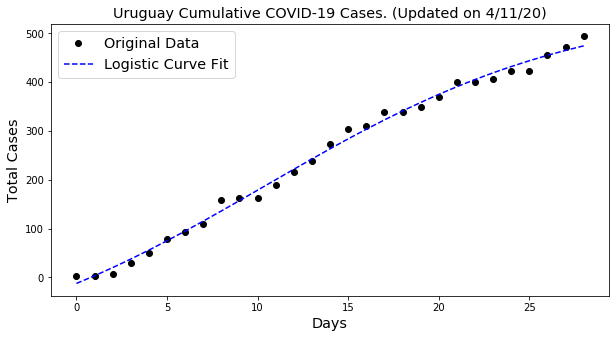



Niger

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 491
	Confirmed cases on 4/4/20 	 144
	Ratio: 3.41
	Weekly increase: 241.0 %
	Daily increase: 19.2 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Logistic Fit**

	R^2: 0.9973853862178653
	Doubling Time (during middle of growth):  4.14 (± 0.52 ) days
	param:  [ 4.95551365e+02  3.35042562e-01 -2.43542135e+00  6.41569989e+02]

** Based on Exponential Fit **

	R^2: 0.9856268920231261
	Doubling Time (represents overall growth):  4.47 (± 0.67 ) days
	param:  [ 18.62226793   0.15502033 -37.58610632]


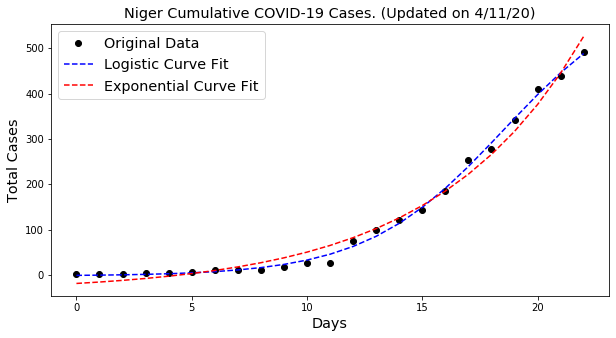



Burkina Faso

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 484
	Confirmed cases on 4/4/20 	 318
	Ratio: 1.52
	Weekly increase: 52.2 %
	Daily increase: 6.2 % per day
	Doubling Time (represents recent growth): 11.6 days

** Based on Logistic Fit**

	R^2: 0.9940653391292308
	Doubling Time (during middle of growth):  10.22 (± 2.22 ) days
	param:  [ 1.97513827e+01  1.35675037e-01 -4.71254361e+01  5.92736788e+02]

** Based on Exponential Fit **

	R^2: 0.9791478625723411
	Doubling Time (represents overall growth):  12.0 (± 2.83 ) days
	param:  [ 9.68557183e+01  5.77760896e-02 -1.00000000e+02]


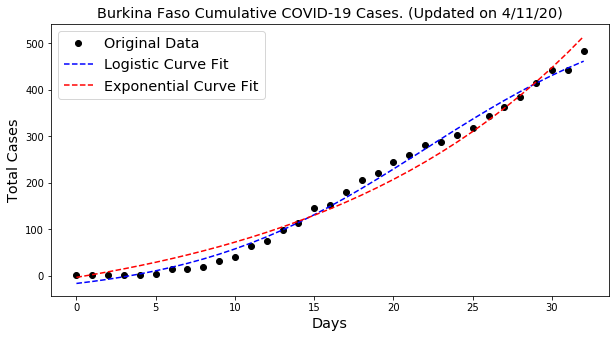



Bangladesh

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 482
	Confirmed cases on 4/4/20 	 70
	Ratio: 6.89
	Weekly increase: 588.6 %
	Daily increase: 31.7 % per day
	Doubling Time (represents recent growth): 2.5 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9800055608368518
	Doubling Time (represents overall growth):  2.5 (± 0.26 ) days
	param:  [ 0.03901022  0.27766326 16.87405546]


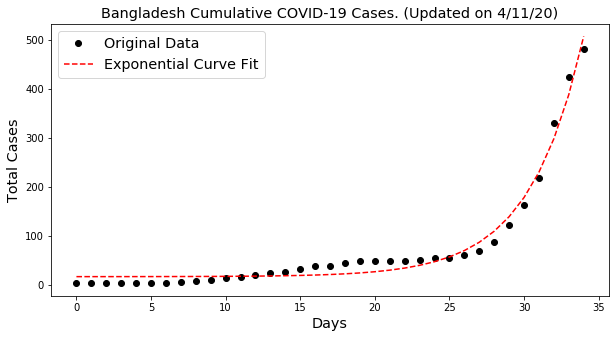



Albania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 433
	Confirmed cases on 4/4/20 	 333
	Ratio: 1.3
	Weekly increase: 30.0 %
	Daily increase: 3.8 % per day
	Doubling Time (represents recent growth): 18.5 days

** Based on Logistic Fit**

	R^2: 0.9968825686092868
	Doubling Time (during middle of growth):  9.43 (± 1.3 ) days
	param:  [ 2.78525394e+01  1.46985840e-01 -6.99444232e+00  5.32824742e+02]

** Based on Exponential Fit **

	R^2: 0.9836175562745815
	Doubling Time (represents overall growth):  13.1 (± 2.78 ) days
	param:  [ 1.00000000e+02  5.29304043e-02 -9.12303972e+01]


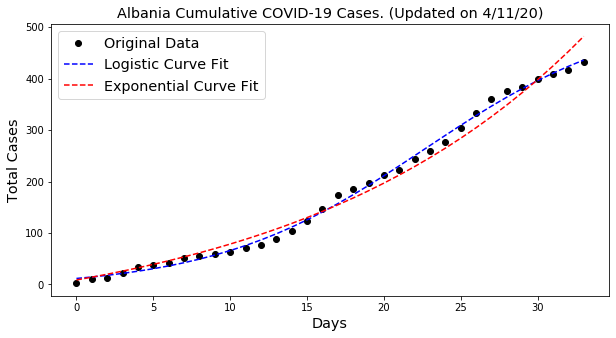



Ghana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 408
	Confirmed cases on 4/4/20 	 205
	Ratio: 1.99
	Weekly increase: 99.0 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9668555566680405
	Doubling Time (during middle of growth):  24.1 (± nan ) days
	param:  [ 1.91065596e+07  5.75198475e-02 -1.13401381e+02  1.95525281e+09]

** Based on Exponential Fit **

	R^2: 0.9667382546159495
	Doubling Time (represents overall growth):  11.43 (± 3.87 ) days
	param:  [ 9.17248801e+01  6.06589212e-02 -1.00000000e+02]


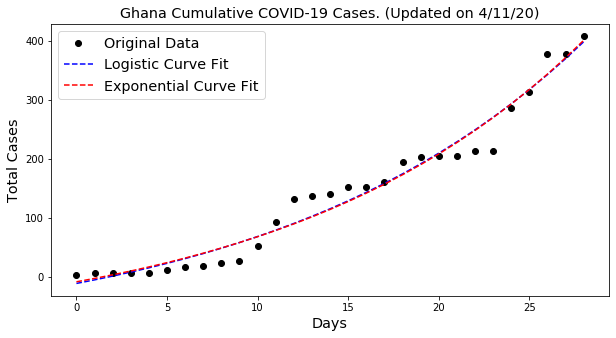



Honduras

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 392
	Confirmed cases on 4/4/20 	 264
	Ratio: 1.48
	Weekly increase: 48.5 %
	Daily increase: 5.8 % per day
	Doubling Time (represents recent growth): 12.3 days

** Based on Logistic Fit**

	R^2: 0.9951824649487944
	Doubling Time (during middle of growth):  5.94 (± 0.8 ) days
	param:  [ 1.98286630e+02  2.33504916e-01 -1.99713074e+00  4.33020038e+02]

** Based on Exponential Fit **

	R^2: 0.9781612240482424
	Doubling Time (represents overall growth):  9.43 (± 1.91 ) days
	param:  [ 50.64367373   0.07349953 -72.32699034]


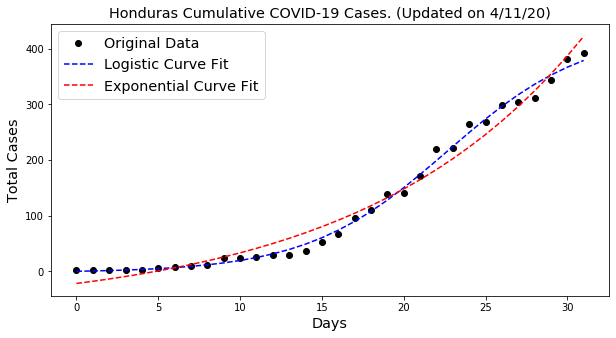



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 385
	Confirmed cases on 4/4/20 	 355
	Ratio: 1.08
	Weekly increase: 8.5 %
	Daily increase: 1.2 % per day
	Doubling Time (represents recent growth): 59.8 days

** Based on Logistic Fit**

	R^2: 0.9948130743358756
	Doubling Time (during middle of growth):  6.77 (± 0.51 ) days
	param:  [3.19433344e+05 2.04657637e-01 1.92572609e+01 3.93706306e+02]

 exponential R^2  0.9496506840109121


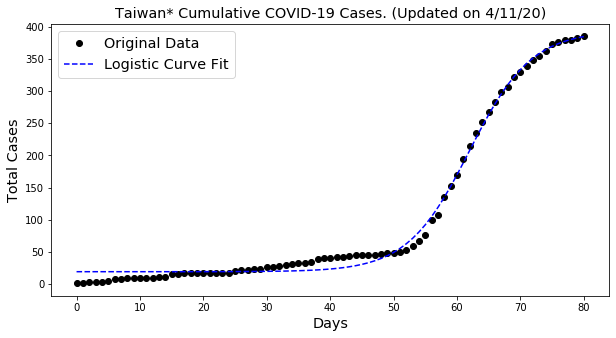



Jordan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 381
	Confirmed cases on 4/4/20 	 323
	Ratio: 1.18
	Weekly increase: 18.0 %
	Daily increase: 2.4 % per day
	Doubling Time (represents recent growth): 29.4 days

** Based on Logistic Fit**

	R^2: 0.9949527651701323
	Doubling Time (during middle of growth):  6.29 (± 0.68 ) days
	param:  [ 1.42558096e+02  2.20399148e-01 -1.15417430e+01  3.76342484e+02]

 exponential R^2  0.9410373692833556


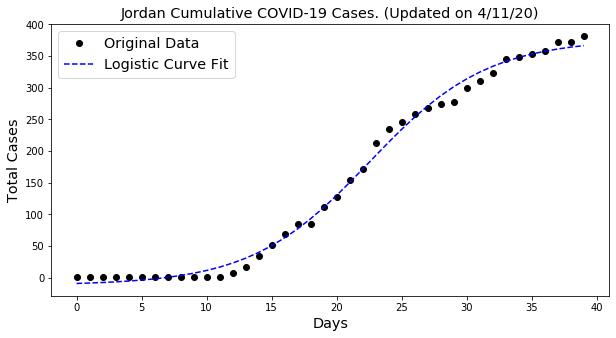



Malta

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 370
	Confirmed cases on 4/4/20 	 213
	Ratio: 1.74
	Weekly increase: 73.7 %
	Daily increase: 8.2 % per day
	Doubling Time (represents recent growth): 8.8 days

** Based on Logistic Fit**

	R^2: 0.9895558477007752
	Doubling Time (during middle of growth):  27.97 (± 19.17 ) days
	param:  [ 8.47403181e+06  4.95639623e-02 -8.68094423e+01  6.73255347e+08]

** Based on Exponential Fit **

	R^2: 0.9895558490908599
	Doubling Time (represents overall growth):  13.98 (± 2.29 ) days
	param:  [ 7.94491899e+01  4.95639655e-02 -8.68093665e+01]


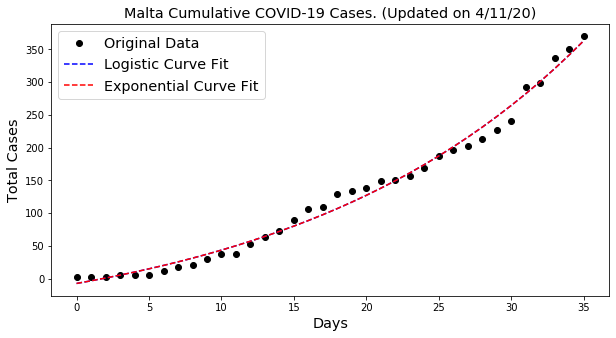



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 356
	Confirmed cases on 4/4/20 	 259
	Ratio: 1.37
	Weekly increase: 37.5 %
	Daily increase: 4.6 % per day
	Doubling Time (represents recent growth): 15.3 days

** Based on Logistic Fit**

	R^2: 0.9845377422883095
	Doubling Time (during middle of growth):  19.48 (± 8.88 ) days
	param:  [ 6.38034510e+00  7.11695347e-02 -8.36521583e+01  4.37694376e+02]

** Based on Exponential Fit **

	R^2: 0.9615545552053223
	Doubling Time (represents overall growth):  20.12 (± 6.53 ) days
	param:  [ 1.00000000e+02  3.44469932e-02 -8.93216129e+01]


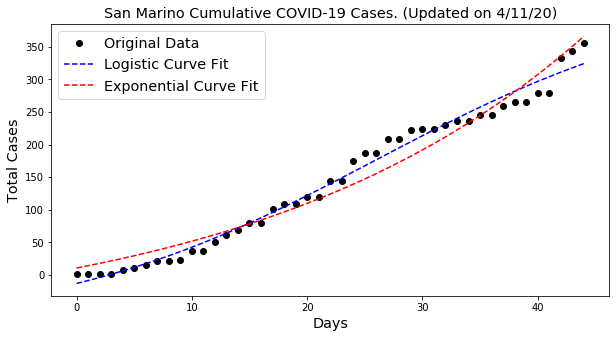



Kyrgyzstan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 339
	Confirmed cases on 4/4/20 	 144
	Ratio: 2.35
	Weekly increase: 135.4 %
	Daily increase: 13.0 % per day
	Doubling Time (represents recent growth): 5.7 days

** Based on Logistic Fit**

	R^2: 0.9885280193405935
	Doubling Time (during middle of growth):  14.72 (± 13.83 ) days
	param:  [ 3.57151600e+06  9.41479894e-02 -3.84088482e+01  1.41644312e+08]

** Based on Exponential Fit **

	R^2: 0.9885280199360302
	Doubling Time (represents overall growth):  7.36 (± 1.24 ) days
	param:  [ 39.65957656   0.09414779 -38.40898883]


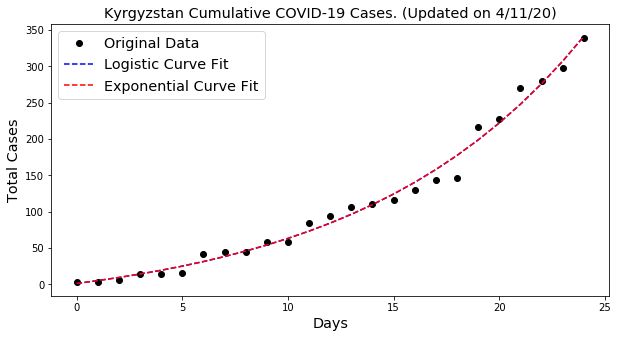



Mauritius

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 319
	Confirmed cases on 4/4/20 	 196
	Ratio: 1.63
	Weekly increase: 62.8 %
	Daily increase: 7.2 % per day
	Doubling Time (represents recent growth): 10.0 days

** Based on Logistic Fit**

	R^2: 0.9954577594932614
	Doubling Time (during middle of growth):  11.87 (± 4.77 ) days
	param:  [ 9.07590778e+00  1.16802588e-01 -6.30234553e+01  5.46891820e+02]

** Based on Exponential Fit **

	R^2: 0.9871235561019447
	Doubling Time (represents overall growth):  11.12 (± 2.82 ) days
	param:  [ 1.00000000e+02  6.23461318e-02 -9.26805151e+01]


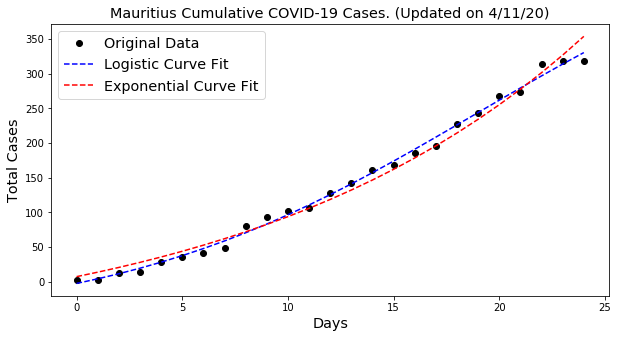



Nigeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 318
	Confirmed cases on 4/4/20 	 214
	Ratio: 1.49
	Weekly increase: 48.6 %
	Daily increase: 5.8 % per day
	Doubling Time (represents recent growth): 12.3 days

** Based on Logistic Fit**

	R^2: 0.9974701230155606
	Doubling Time (during middle of growth):  6.23 (± 0.47 ) days
	param:  [ 1.74533882e+03  2.22627722e-01 -1.73094140e+00  3.44778131e+02]

** Based on Exponential Fit **

	R^2: 0.9732563547155542
	Doubling Time (represents overall growth):  8.66 (± 1.24 ) days
	param:  [ 12.21100799   0.08007369 -29.09336328]


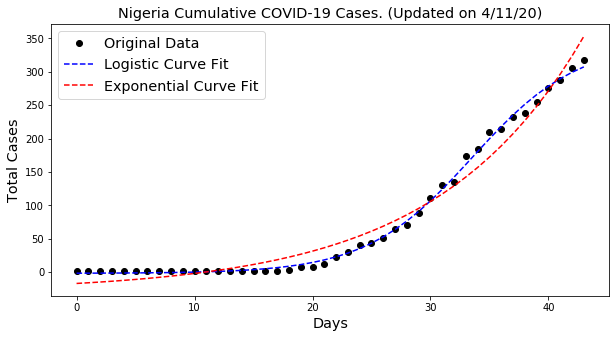



Kosovo

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 283
	Confirmed cases on 4/4/20 	 135
	Ratio: 2.1
	Weekly increase: 109.6 %
	Daily increase: 11.2 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9628271633193104
	Doubling Time (during middle of growth):  7.29 (± 2.98 ) days
	param:  [2.63039286e+08 1.90118436e-01 7.87919231e+01 2.44607206e+09]

** Based on Exponential Fit **

	R^2: 0.962827164572464
	Doubling Time (represents overall growth):  3.65 (± 1.13 ) days
	param:  [ 9.2994374   0.19011731 78.79159867]


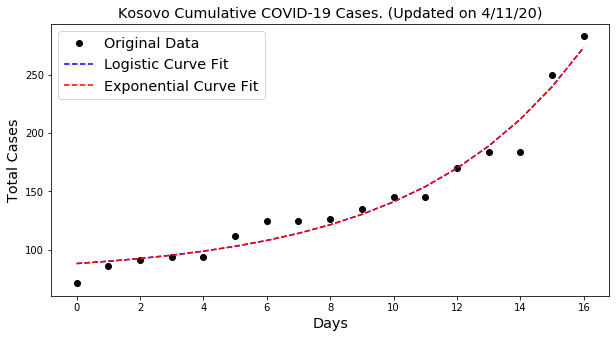



Senegal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 278
	Confirmed cases on 4/4/20 	 219
	Ratio: 1.27
	Weekly increase: 26.9 %
	Daily increase: 3.5 % per day
	Doubling Time (represents recent growth): 20.3 days

** Based on Logistic Fit**

	R^2: 0.9974708306232676
	Doubling Time (during middle of growth):  7.53 (± 0.62 ) days
	param:  [ 1.38332883e+02  1.84207485e-01 -2.94149452e+00  2.87294545e+02]

** Based on Exponential Fit **

	R^2: 0.9749049131043058
	Doubling Time (represents overall growth):  16.29 (± 3.96 ) days
	param:  [ 7.10801397e+01  4.25414971e-02 -9.13412866e+01]


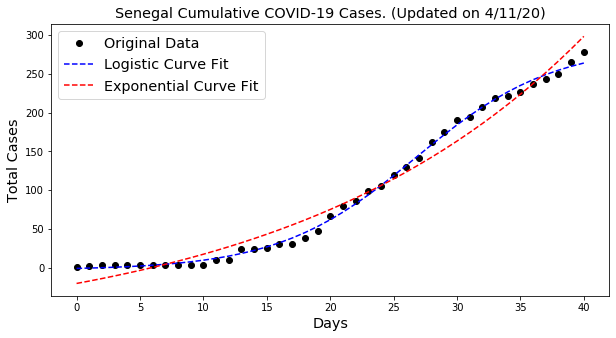



Bolivia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 275
	Confirmed cases on 4/4/20 	 139
	Ratio: 1.98
	Weekly increase: 97.8 %
	Daily increase: 10.2 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.9917645546701627
	Doubling Time (during middle of growth):  10.6 (± 3.24 ) days
	param:  [ 7.23933908e+01  1.30799924e-01 -9.05496932e+00  6.49193404e+02]

** Based on Exponential Fit **

	R^2: 0.990393043181052
	Doubling Time (represents overall growth):  7.95 (± 0.94 ) days
	param:  [ 21.23894759   0.08713596 -25.51537668]


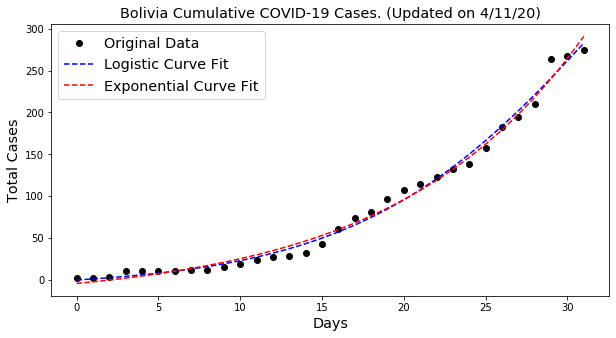



West Bank and Gaza

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 268
	Confirmed cases on 4/4/20 	 217
	Ratio: 1.24
	Weekly increase: 23.5 %
	Daily increase: 3.1 % per day
	Doubling Time (represents recent growth): 23.0 days

** Based on Logistic Fit**

	R^2: 0.9859575308802695
	Doubling Time (during middle of growth):  5.99 (± 1.18 ) days
	param:  [6.21724204e+02 2.31491419e-01 2.47788270e+01 3.13989856e+02]

** Based on Exponential Fit **

	R^2: 0.9652253467125158
	Doubling Time (represents overall growth):  10.28 (± 2.26 ) days
	param:  [ 27.49625446   0.06741066 -22.11744832]


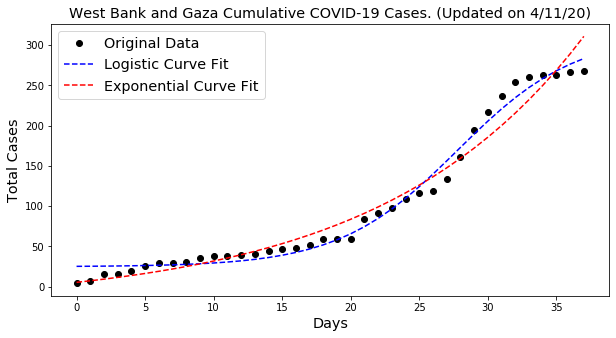



Montenegro

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 263
	Confirmed cases on 4/4/20 	 201
	Ratio: 1.31
	Weekly increase: 30.8 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 18.0 days

** Based on Logistic Fit**

	R^2: 0.989220768832323
	Doubling Time (during middle of growth):  6.45 (± 1.72 ) days
	param:  [ 2.93507560e+01  2.14852507e-01 -5.77896625e+00  3.08942900e+02]

** Based on Exponential Fit **

	R^2: 0.9711911450920037
	Doubling Time (represents overall growth):  12.5 (± 5.04 ) days
	param:  [ 1.00000000e+02  5.54665795e-02 -1.00000000e+02]


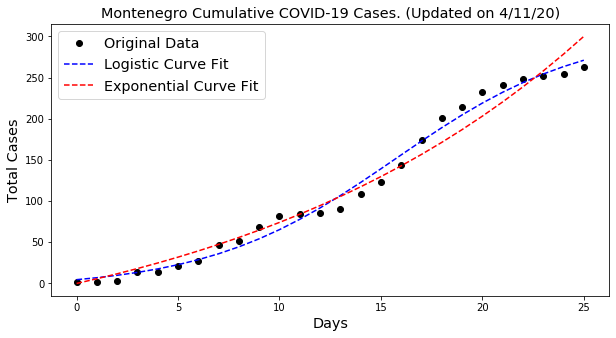



Vietnam

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 258
	Confirmed cases on 4/4/20 	 240
	Ratio: 1.08
	Weekly increase: 7.5 %
	Daily increase: 1.0 % per day
	Doubling Time (represents recent growth): 67.1 days

** Based on Logistic Fit**

	R^2: 0.9971693448713213
	Doubling Time (during middle of growth):  8.28 (± 0.47 ) days
	param:  [3.11194701e+04 1.67387295e-01 1.01953251e+01 2.76852830e+02]

** Based on Exponential Fit **

	R^2: 0.9589914360751102
	Doubling Time (represents overall growth):  13.99 (± 1.7 ) days
	param:  [  6.42519412   0.04955365 -11.53270032]


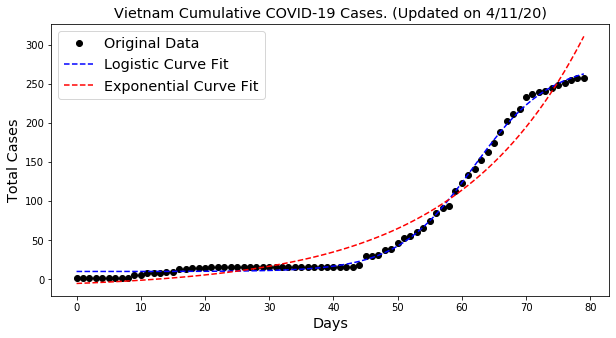



Guinea

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 250
	Confirmed cases on 4/4/20 	 111
	Ratio: 2.25
	Weekly increase: 125.2 %
	Daily increase: 12.3 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9905461180126254
	Doubling Time (during middle of growth):  4.62 (± 0.91 ) days
	param:  [ 1.86827064e+03  3.00308742e-01 -1.15119923e+00  3.10097214e+02]

** Based on Exponential Fit **

	R^2: 0.9791034959765768
	Doubling Time (represents overall growth):  4.59 (± 0.63 ) days
	param:  [  3.40372948   0.1509086  -10.96880052]


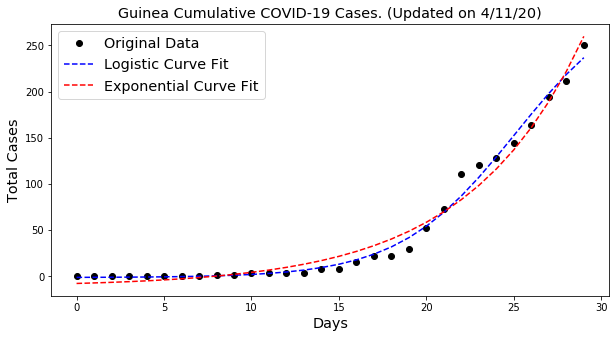



Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 242
	Confirmed cases on 4/4/20 	 162
	Ratio: 1.49
	Weekly increase: 49.4 %
	Daily increase: 5.9 % per day
	Doubling Time (represents recent growth): 12.1 days

** Based on Logistic Fit**

	R^2: 0.9968154906451169
	Doubling Time (during middle of growth):  15.71 (± 2.55 ) days
	param:  [ 9.47132715e+01  8.82374841e-02 -7.58180626e+00  7.05330327e+02]

** Based on Exponential Fit **

	R^2: 0.9960723428126904
	Doubling Time (represents overall growth):  10.73 (± 0.63 ) days
	param:  [ 14.83859891   0.06460934 -18.02300711]


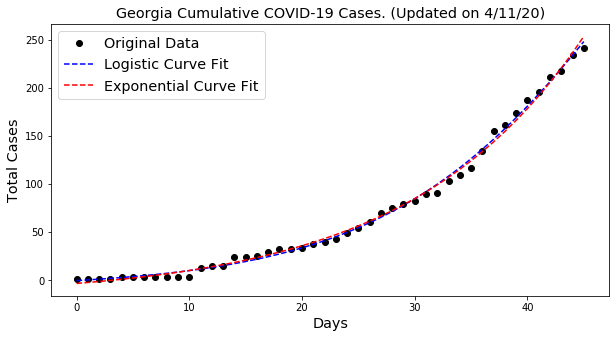



Congo (Kinshasa)

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 223
	Confirmed cases on 4/4/20 	 154
	Ratio: 1.45
	Weekly increase: 44.8 %
	Daily increase: 5.4 % per day
	Doubling Time (represents recent growth): 13.1 days

** Based on Logistic Fit**

	R^2: 0.991863935794944
	Doubling Time (during middle of growth):  8.59 (± 1.95 ) days
	param:  [ 4.35232472e+01  1.61463121e-01 -8.58082996e+00  2.80647968e+02]

** Based on Exponential Fit **

	R^2: 0.9850808225343077
	Doubling Time (represents overall growth):  12.37 (± 2.58 ) days
	param:  [ 5.14884893e+01  5.60542694e-02 -6.28069245e+01]


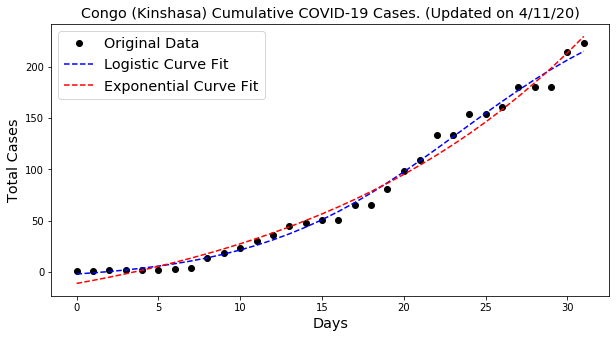



Sri Lanka

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 198
	Confirmed cases on 4/4/20 	 166
	Ratio: 1.19
	Weekly increase: 19.3 %
	Daily increase: 2.6 % per day
	Doubling Time (represents recent growth): 27.5 days

** Based on Logistic Fit**

	R^2: 0.9891764183486466
	Doubling Time (during middle of growth):  8.12 (± 0.92 ) days
	param:  [ 2.12476117e+04  1.70666639e-01 -1.36580516e+00  2.01618972e+02]

 exponential R^2  0.9492050046597814


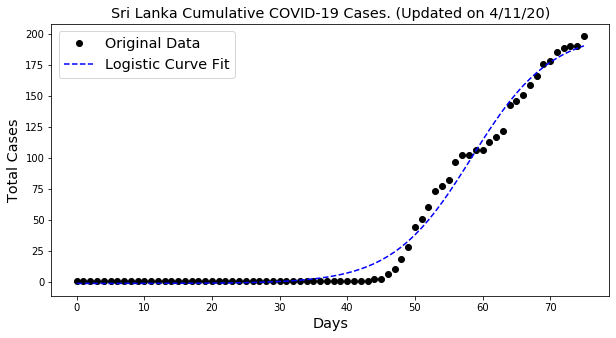



Kenya

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 191
	Confirmed cases on 4/4/20 	 126
	Ratio: 1.52
	Weekly increase: 51.6 %
	Daily increase: 6.1 % per day
	Doubling Time (represents recent growth): 11.7 days

** Based on Logistic Fit**

	R^2: 0.9945694461992708
	Doubling Time (during middle of growth):  4.62 (± 0.63 ) days
	param:  [4.64721071e+02 3.00085539e-01 4.20950318e+00 2.09546775e+02]

** Based on Exponential Fit **

	R^2: 0.9671761096552481
	Doubling Time (represents overall growth):  9.51 (± 2.61 ) days
	param:  [ 31.62908783   0.07285145 -42.6848203 ]


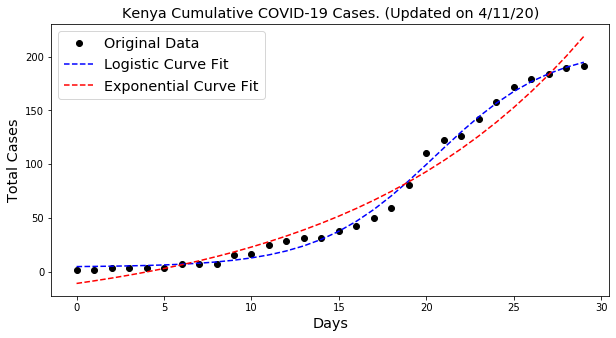



Djibouti

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 187
	Confirmed cases on 4/4/20 	 50
	Ratio: 3.74
	Weekly increase: 274.0 %
	Daily increase: 20.7 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.9888994049199848
	Doubling Time (during middle of growth):  6.65 (± 2.32 ) days
	param:  [ 2.85307310e+02  2.08340508e-01 -1.19426051e+00  5.39161255e+02]

** Based on Exponential Fit **

	R^2: 0.9880485619505743
	Doubling Time (represents overall growth):  4.33 (± 0.52 ) days
	param:  [ 4.12424439  0.16022657 -5.45621063]


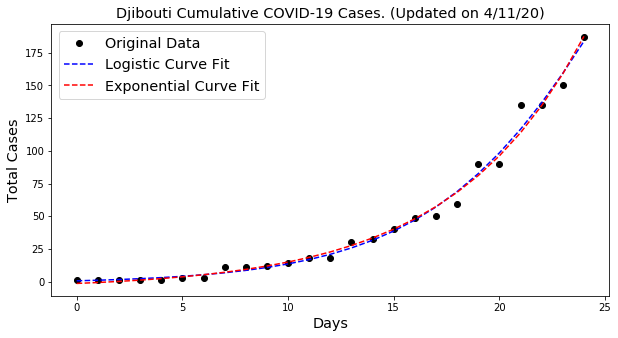



Venezuela

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 175
	Confirmed cases on 4/4/20 	 155
	Ratio: 1.13
	Weekly increase: 12.9 %
	Daily increase: 1.7 % per day
	Doubling Time (represents recent growth): 40.0 days

** Based on Logistic Fit**

	R^2: 0.9959119667640091
	Doubling Time (during middle of growth):  10.25 (± 2.36 ) days
	param:  [ 2.54542518e+00  1.35197358e-01 -6.93081806e+01  1.88800438e+02]

 exponential R^2  0.9046033223329738


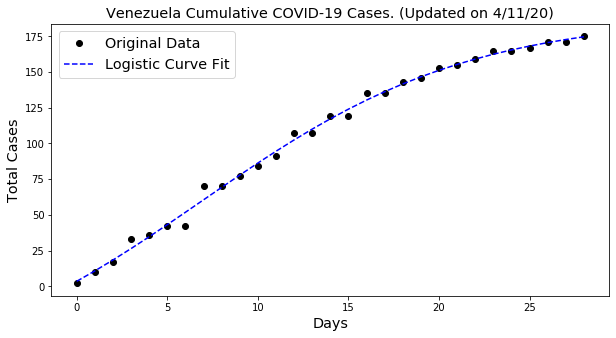



Guatemala

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 137
	Confirmed cases on 4/4/20 	 61
	Ratio: 2.25
	Weekly increase: 124.6 %
	Daily increase: 12.3 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.9822513645403059
	Doubling Time (during middle of growth):  11.98 (± nan ) days
	param:  [2.14824262e+08 1.15682334e-01 1.50362251e+00 1.08606624e+09]

** Based on Exponential Fit **

	R^2: 0.9822513660623774
	Doubling Time (represents overall growth):  5.99 (± 0.9 ) days
	param:  [5.0556369 0.1156821 1.5035558]


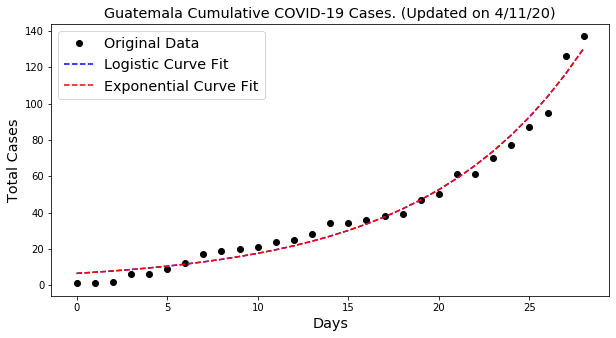



Brunei

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 136
	Confirmed cases on 4/4/20 	 135
	Ratio: 1.01
	Weekly increase: 0.7 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 657.4 days

** Based on Logistic Fit**

	R^2: 0.9932382376927562
	Doubling Time (during middle of growth):  9.1 (± 1.87 ) days
	param:  [  2.20871437   0.15231218 -66.59678406 141.64748851]

 exponential R^2  0.8169326755003441


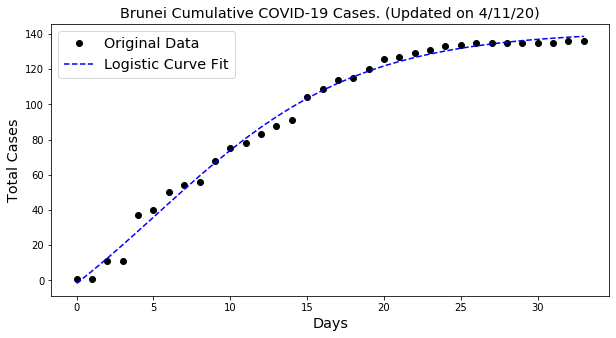



Paraguay

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 133
	Confirmed cases on 4/4/20 	 96
	Ratio: 1.39
	Weekly increase: 38.5 %
	Daily increase: 4.8 % per day
	Doubling Time (represents recent growth): 14.9 days

** Based on Logistic Fit**

	R^2: 0.995715322444584
	Doubling Time (during middle of growth):  8.31 (± 1.16 ) days
	param:  [ 59.59936294   0.16686034  -1.79313361 160.82274058]

** Based on Exponential Fit **

	R^2: 0.9843270618448898
	Doubling Time (represents overall growth):  13.66 (± 2.8 ) days
	param:  [ 32.56016566   0.05073842 -38.61870698]


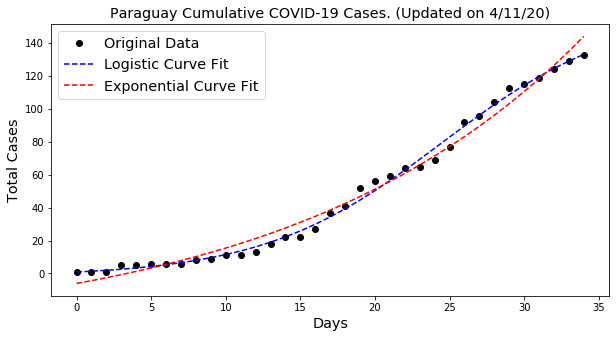



Rwanda

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 120
	Confirmed cases on 4/4/20 	 102
	Ratio: 1.18
	Weekly increase: 17.6 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 29.9 days

** Based on Logistic Fit**

	R^2: 0.994385942572913
	Doubling Time (during middle of growth):  8.2 (± 1.66 ) days
	param:  [ 10.04840506   0.16900122 -14.33807997 129.24252394]

** Based on Exponential Fit **

	R^2: 0.9695830117490145
	Doubling Time (represents overall growth):  23.06 (± 14.38 ) days
	param:  [ 1.00000000e+02  3.00547165e-02 -9.82774104e+01]


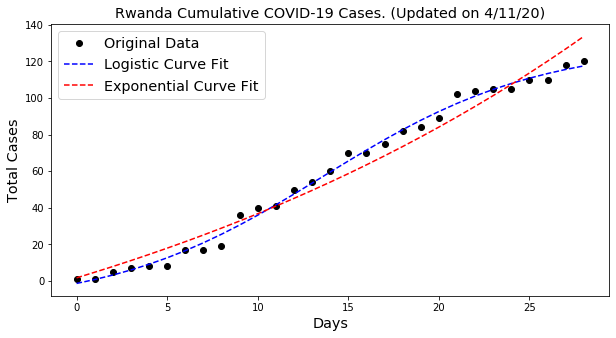



Cambodia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 120
	Confirmed cases on 4/4/20 	 114
	Ratio: 1.05
	Weekly increase: 5.3 %
	Daily increase: 0.7 % per day
	Doubling Time (represents recent growth): 94.6 days

** Based on Logistic Fit**

	R^2: 0.9949555267347558
	Doubling Time (during middle of growth):  3.63 (± 0.33 ) days
	param:  [7.64413652e+08 3.81589009e-01 6.96005315e-01 1.13548197e+02]

 exponential R^2  0.8819119736668688


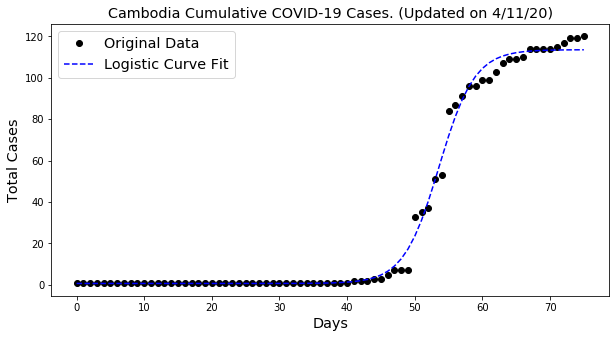



El Salvador

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 118
	Confirmed cases on 4/4/20 	 56
	Ratio: 2.11
	Weekly increase: 110.7 %
	Daily increase: 11.2 % per day
	Doubling Time (represents recent growth): 6.5 days

** Based on Logistic Fit**

	R^2: 0.9958145240577614
	Doubling Time (during middle of growth):  8.99 (± 2.68 ) days
	param:  [ 4.52891738e+01  1.54134936e-01 -6.45371260e+00  2.91833367e+02]

** Based on Exponential Fit **

	R^2: 0.9947547177129723
	Doubling Time (represents overall growth):  7.0 (± 0.81 ) days
	param:  [ 14.56515071   0.09895686 -16.43026911]


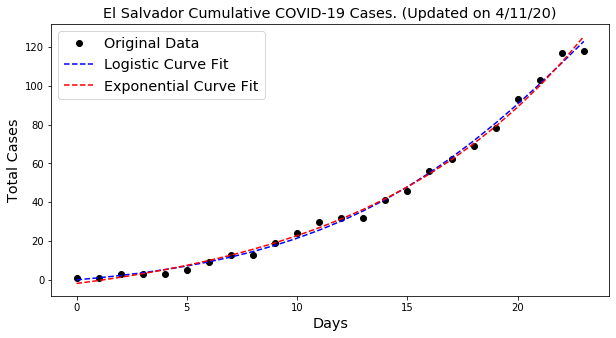



Trinidad and Tobago

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 112
	Confirmed cases on 4/4/20 	 103
	Ratio: 1.09
	Weekly increase: 8.7 %
	Daily increase: 1.2 % per day
	Doubling Time (represents recent growth): 57.9 days

** Based on Logistic Fit**

	R^2: 0.9759567821901131
	Doubling Time (during middle of growth):  7.7 (± 3.13 ) days
	param:  [  4.5111895    0.18008403 -31.40986866 114.30094534]

 exponential R^2  0.8867663697002679


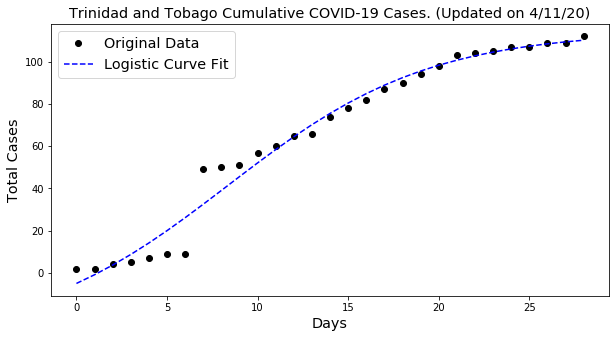



Madagascar

** Based on Most Recent Week of Data **

	Confirmed cases on 4/11/20 	 102
	Confirmed cases on 4/4/20 	 70
	Ratio: 1.46
	Weekly increase: 45.7 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 12.9 days

** Based on Logistic Fit**

	R^2: 0.991132629730723
	Doubling Time (during middle of growth):  7.7 (± 2.74 ) days
	param:  [  7.5133802    0.17998988 -13.89468925 115.6823525 ]

** Based on Exponential Fit **

	R^2: 0.9772394351095954
	Doubling Time (represents overall growth):  21.06 (± 14.77 ) days
	param:  [ 1.00000000e+02  3.29111485e-02 -9.70700510e+01]


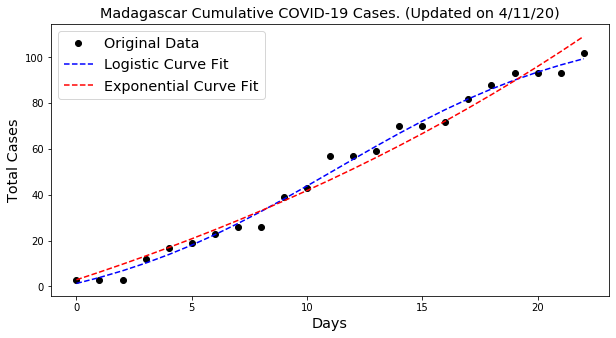

In [6]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

cnames = topcountries.values

for c in cnames:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


     Inferred Doubling Time  95%CI  Recent Doubling Time
0                       6.9    0.2                   9.1
1                       7.1    0.2                  18.9
2                       9.2    0.3                  24.2
3                       8.5    0.6                  13.3
4                       7.6    0.2                  18.5
5                       6.6    0.5                 852.7
6                       7.9    0.3                   7.7
7                      13.9    1.3                  21.3
8                       7.3    0.7                   6.2
9                       7.6    0.3                  11.6
10                      7.8    0.5                  24.0
11                      8.8    0.6                  12.6
12                      7.0    0.2                 

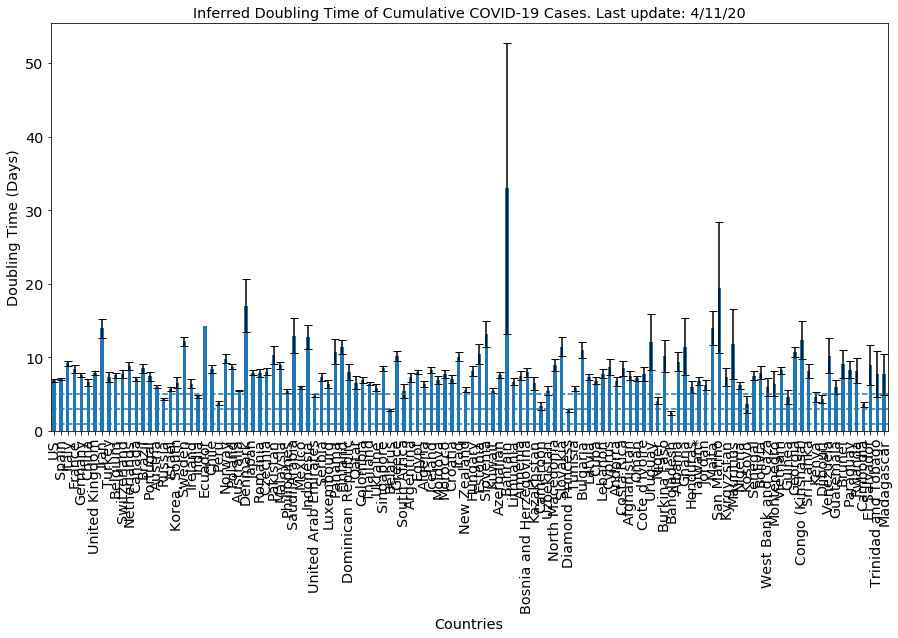

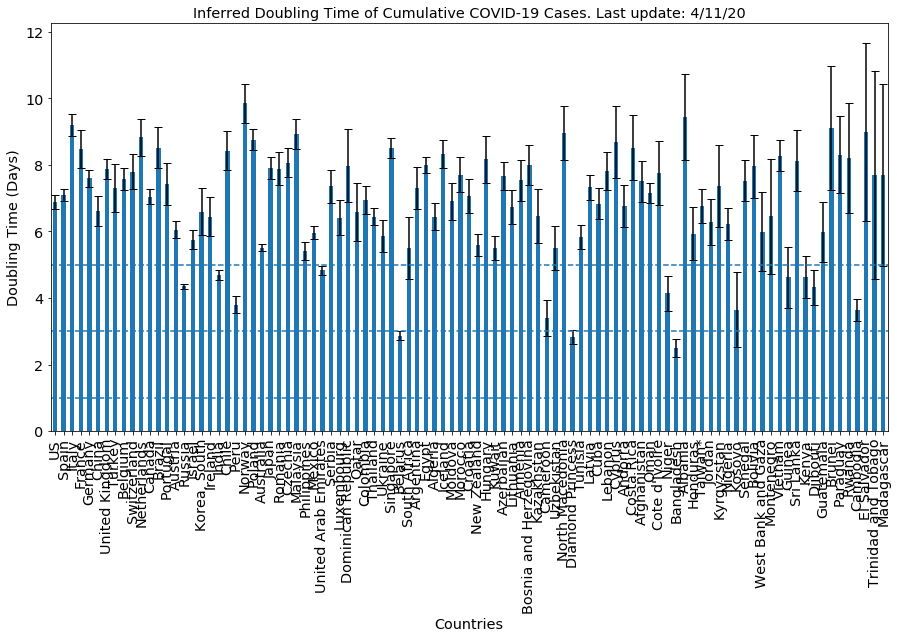

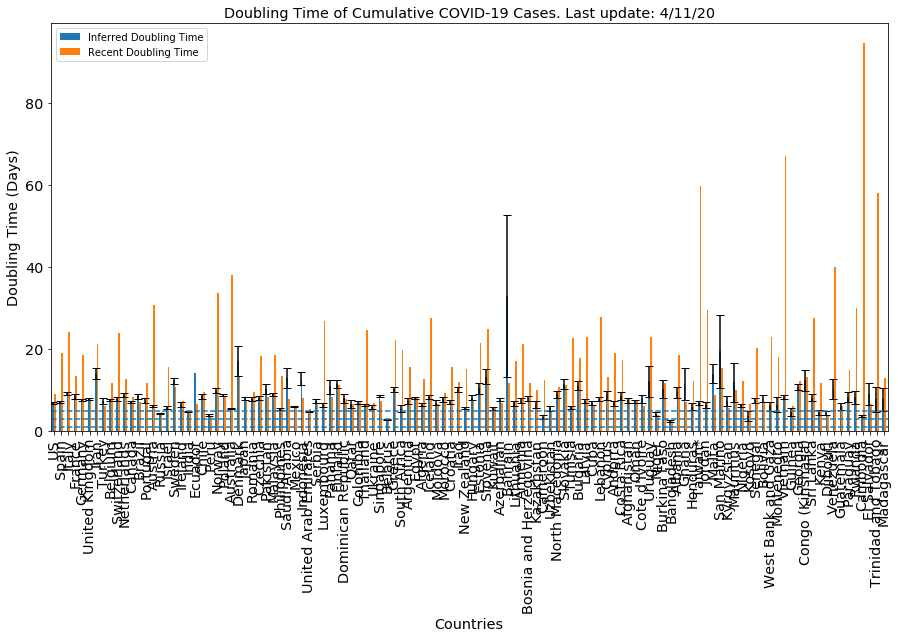

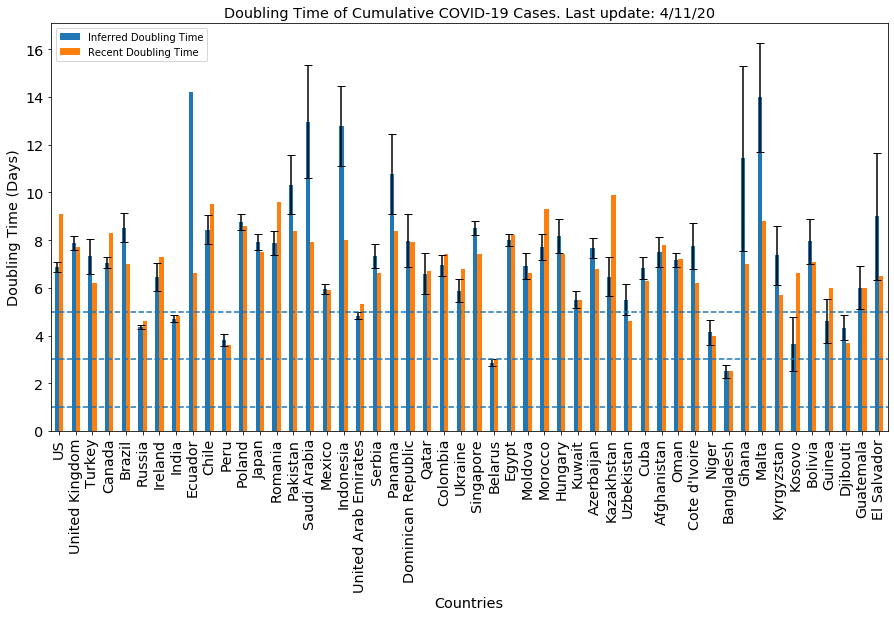

In [7]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()